# Imports and cleaning

## Import the moduls

In [1]:
import tarfile
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import csv
import pickle
import networkx as nx
import statsmodels.formula.api as smf
#from wordcloud import WordCloud
%matplotlib inline

## Import the data

In [2]:
# File and folder names
DATA_FOLDER = 'Data/'
CHARACTER_DATASET = DATA_FOLDER + 'characters.pkl'
MOVIE_DATASET = DATA_FOLDER + 'movies.pkl'

SUMMARIES_DATASET = DATA_FOLDER + 'plot_summaries.txt'
NLP_DATASET = DATA_FOLDER + 'corenlp_plot_summaries.tar'

MALE_SENTENCES = DATA_FOLDER + "male_sentences.pkl"
FEMALE_SENTENCES = DATA_FOLDER + "female_sentences.pkl"

MALE_SENTIMENTS = DATA_FOLDER + "male_sentiments.pkl"
FEMALE_SENTIMENTS = DATA_FOLDER + "female_sentiments.pkl"

# Additional datasets
CMU_IMDB = DATA_FOLDER + 'merge_CMU_IMDb.pkl'
ALL_DATASETS = DATA_FOLDER + 'merge_all.pkl'

In [3]:
# Function to load data
def load_metadata(path, column_names, header=None, low_memory=False):
    return pd.read_table(path, header=header, names=column_names)

In [4]:
# Load data
characters = pd.read_pickle(CHARACTER_DATASET)
movies = pd.read_pickle(MOVIE_DATASET)
cmu_imdb = pd.read_pickle(CMU_IMDB)
df_all = pd.read_pickle(ALL_DATASETS)

## Little cleaning

As we pickled our data, we just have to turn the dates back to the pandas datetime format.

We also keep a version of our datasets without dropping the NaN (which are quite numerous, see below).

### Dates as datetime

In [6]:
def col_to_year_fmt(df,col_name):
    '''change format of column col_name of dataframe df to datetime year format'''
    df[col_name] = pd.to_datetime(df[col_name],format='%Y').dt.year

In [7]:
col_to_year_fmt(movies,'Movie_release_date')
col_to_year_fmt(cmu_imdb,'Movie_release_date')
col_to_year_fmt(df_all,'Movie_release_date')
col_to_year_fmt(characters,'Movie_release_date')
col_to_year_fmt(characters,'Actor_date_of_birth') 

### Rows with NaN

We detect the number of rows with NaN values for movies and characters datasets

In [8]:
print('Number of NaN in the movies dataset:\n',movies.isnull().sum())
print('>>> {perc:.2f}% of the rows with at least one NanN'.format(perc=movies.isnull().sum().max()/len(movies)*100))
print('\nNumber of NaN in the characters dataset:\n',characters.isnull().sum())
print('>>> {perc:.2f}% of the rows with at least one NanN'.format(perc=characters.isnull().sum().max()/len(characters)*100))

Number of NaN in the movies dataset:
 Wikipedia_movie_ID              0
Freebase_movie_ID               0
Movie_name                      0
Movie_release_date           6902
Movie_box_office_revenue    73340
Movie_runtime               20450
Movie_languages                 0
Movie_countries                 0
Movie_genres                    0
dtype: int64
>>> 89.72% of the rows with at least one NanN

Number of NaN in the characters dataset:
 Wikipedia_movie_ID                      0
Freebase_movie_ID                       0
Movie_release_date                   9994
Character_name                     257856
Actor_date_of_birth                106145
Actor_gender                        45603
Actor_height_meters                295825
Actor_ethnicity_Freebase_ID        344589
Actor_name                           1228
Actor_age_at_movie_release         158102
Freebase_character_actor_map_ID         0
Freebase_character_ID              257846
Freebase_actor_ID                     815
dtype: i

As in our study we won't use the movie runtime, and in order to keep as many films as possible, we first drop the movie runtime before droping all rows containing NaN.

In [9]:
# We separate the datasets in two parts: one with droped rows with NaN and one that we do not touch
characters_nodrop = characters.copy()
movies_nodrop = movies.copy()

# Drop useless columns
movies.drop(['Movie_runtime'],axis=1, inplace=True)
cmu_imdb.drop(['Movie_runtime'],axis=1, inplace=True)
df_all.drop(['Movie_runtime'],axis=1, inplace=True)


characters = characters.dropna()
movies = movies.dropna()

### Augmentation

As we often work with the logarithm of the revenue, we add new columns `log_revenue` and `log_budget` to our data when possible (we take the **base-10 logarithm**).

In [10]:
def add_log(df,col,new_col):
    '''add the column new_col to the dataframe df, containing the log10 of column col'''
    df[new_col] = df[col].apply(np.log10)

In [11]:
add_log(movies,'Movie_box_office_revenue','log_revenue')
add_log(cmu_imdb,'Movie_box_office_revenue','log_revenue')
add_log(df_all,'Movie_box_office_revenue','log_revenue')
add_log(df_all,'budget','log_budget')

# General visualisations

We begin our trip in this data by some general visualisations and/or statistics, to understand our datasets.

All the visualisations in this first part will be performed on the original datasets (CMU movies, characters and plot summaries), as they are just here to understand what features our data have.

## Movies

In [12]:
movies.head(3)

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_languages,Movie_countries,Movie_genres,log_revenue
0,975900,/m/03vyhn,Ghosts of Mars,2001.0,14010832.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",7.146464
7,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938.0,3600000.0,[English Language],[United States of America],"[Musical, Comedy, Black-and-white]",6.556303
13,171005,/m/016ywb,Henry V,1989.0,10161099.0,[English Language],[United Kingdom],"[Costume drama, War film, Epic, Period piece, ...",7.006941


### General statistics

In [470]:
movies_nodrop.describe()

,Wikipedia_movie_ID,Movie_release_date,Movie_box_office_revenue,Movie_runtime
count,8.174100e+04,74839.000000,8.401000e+03,6.129100e+04
mean,1.740784e+07,1977.489892,4.799363e+07,1.118192e+02
std,1.098791e+07,28.886090,1.121753e+08,4.360070e+03
min,3.300000e+02,1888.000000,1.000000e+04,0.000000e+00
25%,7.323695e+06,1956.000000,2.083193e+06,8.100000e+01
50%,1.777899e+07,1985.000000,1.063969e+07,9.300000e+01
75%,2.715573e+07,2004.000000,4.071696e+07,1.060000e+02
max,3.750192e+07,2016.000000,2.782275e+09,1.079281e+06


As expected, the standard variation for the box office revenue is very high. The use of median or geometric mean for the revenue will be helpful. 

We can already note that $\log\left(\frac{1}{N} \Pi_{i=1}^N X_i \right) = \frac{1}{N} \sum_{i=1}^N \log(X_i)$, meaning that the log of the geometric mean is the arithmetic mean of the log. Therefore we will often use the (arithmetic) mean of the log variables (budget and revenue) as our robust estimators.

### Some evolutions

#### About the revenue

In [13]:
# General parameters for the plots
step = 3 # step for the dates in the x-axis ticks
xmin = int(min(movies.Movie_release_date))
xmax = int(max(movies.Movie_release_date))

Evolution of box office revenue

Text(0.5, 1.0, 'Evolution of median box office revenue per year (log-linear)')

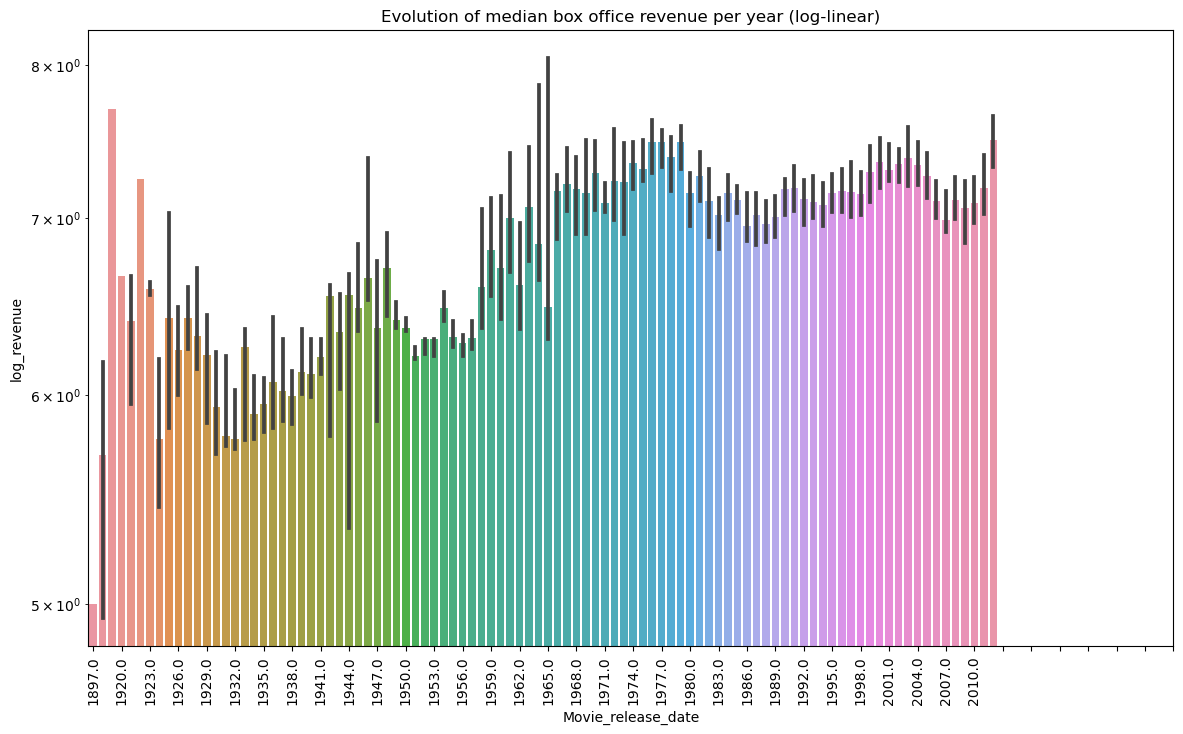

In [19]:
fig,ax = plt.subplots(figsize=(14,8))
sns.barplot(data = movies, x='Movie_release_date', y='log_revenue',estimator='median', ax=ax)
plt.xticks([i for i in range(0,xmax+1-xmin,3)],rotation=90)
plt.yscale('log')
plt.title('Evolution of median box office revenue per year (log-linear)')

The high peaks in 1915 seem strange, as for the relative high revenue around 1921. Let us plot the evolution of the number of films per year (only those with a valid revenue i.e non-NaN).

Text(0.5, 1.0, 'Evolution of number of films per year (log-linear)')

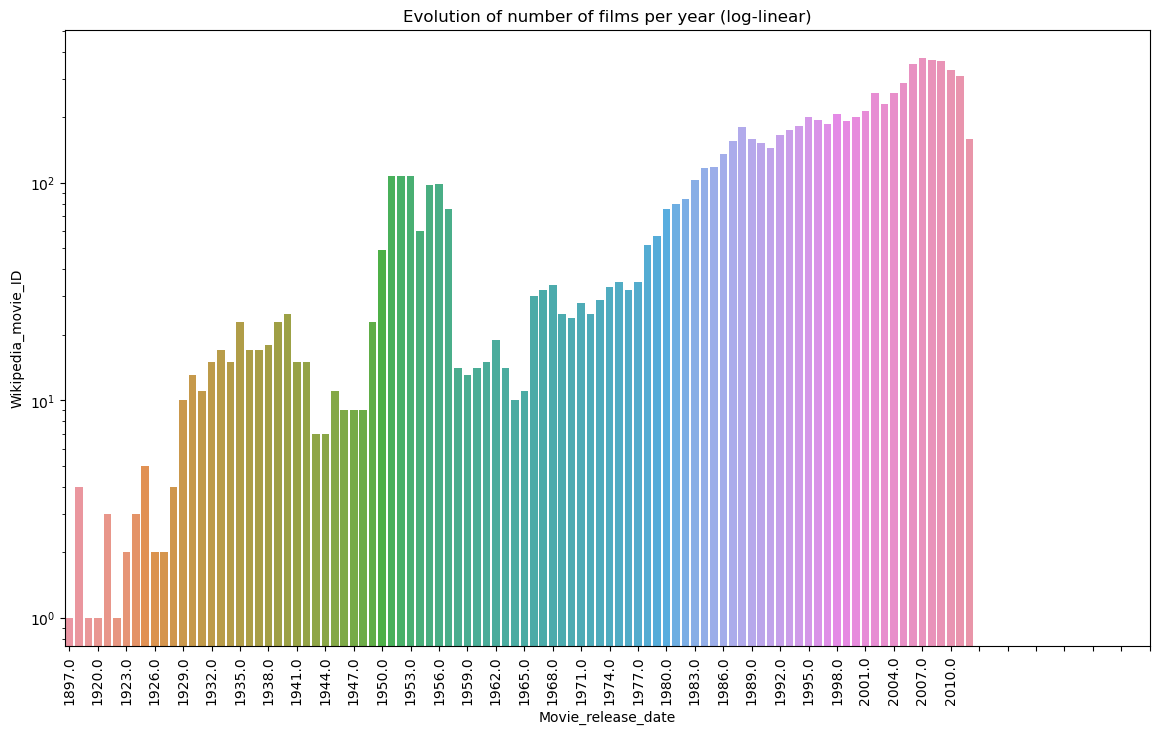

In [20]:
fig,ax = plt.subplots(figsize=(14,8))
sns.barplot(data = movies, x='Movie_release_date', y='Wikipedia_movie_ID',estimator=len, ax=ax)
plt.xticks([i for i in range(0,xmax+1-xmin,3)],rotation=90)
#plt.xticks(rotation=90)
plt.yscale('log')
plt.title('Evolution of number of films per year (log-linear)')

Indeed, there was only one film in 1915, and not a lot around 1921. Only the "best films" of the epoch must have been registered in the dataset. If we investigate evolutions, we might want to begin these after $\approx 1965$ to be sure to have more than 10 films per year.

Now let us see the evolution of the median revenue per film.

Text(0.5, 1.0, 'Evolution of median revenue per film (log-linear)')

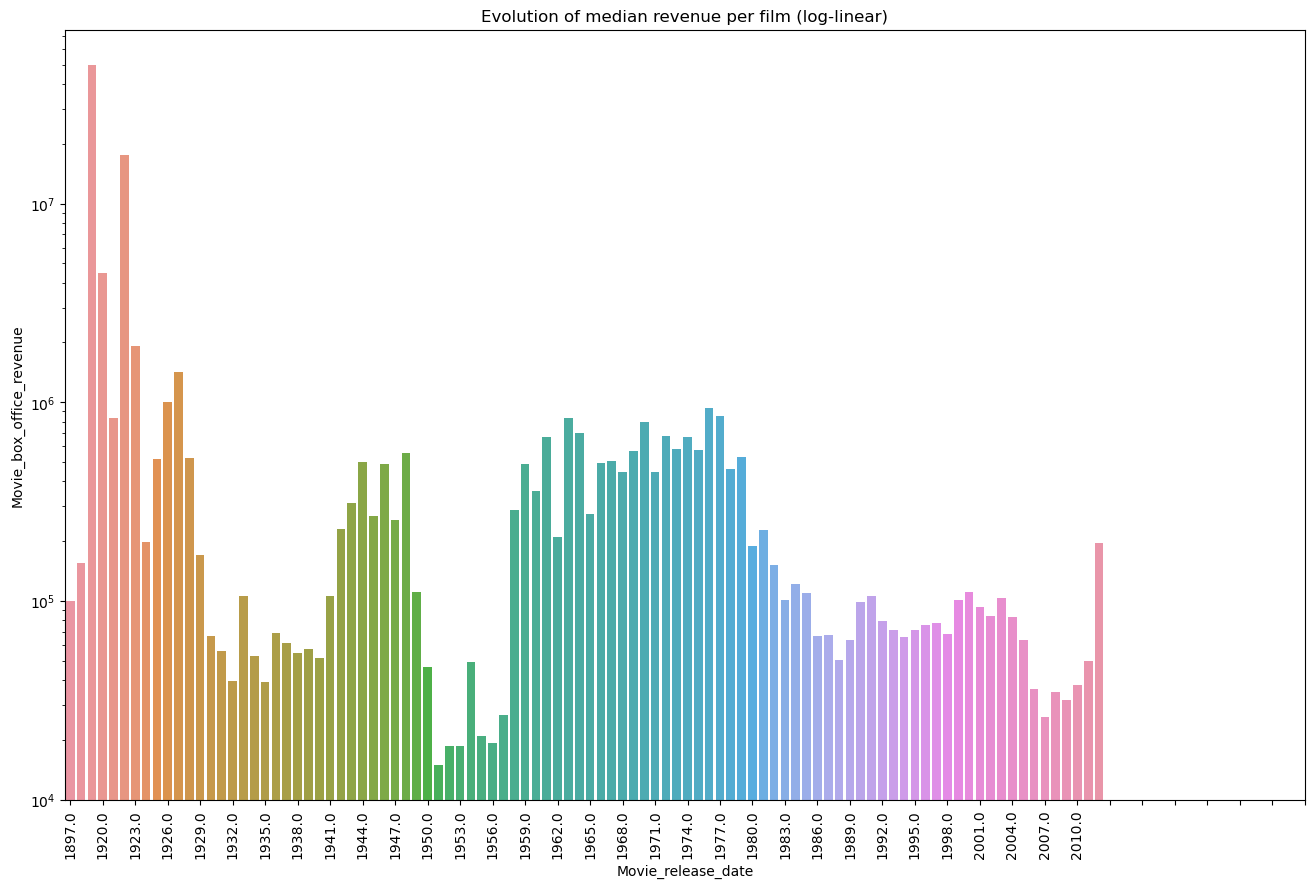

In [21]:
movies_by_year = movies.groupby('Movie_release_date')
movies_by_year_count = movies_by_year.agg('count')
movies_by_year_median = movies_by_year.agg('median',numeric_only=True)
fig,ax = plt.subplots(figsize=(16,10))
sns.barplot(x=movies_by_year_median.index, y=movies_by_year_median.Movie_box_office_revenue/movies_by_year_count.Movie_box_office_revenue, ax=ax)
plt.xticks([i for i in range(0,xmax+1-xmin,3)],rotation=90)
plt.yscale('log')
plt.title('Evolution of median revenue per film (log-linear)')

If we do not take in to account the first few years with very little number of films, iIt appears (not conclusive yet, but just an intuition with the plot) that the median revenue per film is "relatively constant" compared to the median revenue. There was a drop around the 50's (missing data or real effect ?), and a little decrease since 1980.

**About the budget**

(As the budget was not available in the original dataset, this plot is done on the merging of CMU, IMDb and Stats datasets).

Approximately constant mean of log_budget -> approximately constant geometric mean budget

Text(0.5, 1.0, 'Evolution of mean film (log) budget per year (log-linear)')

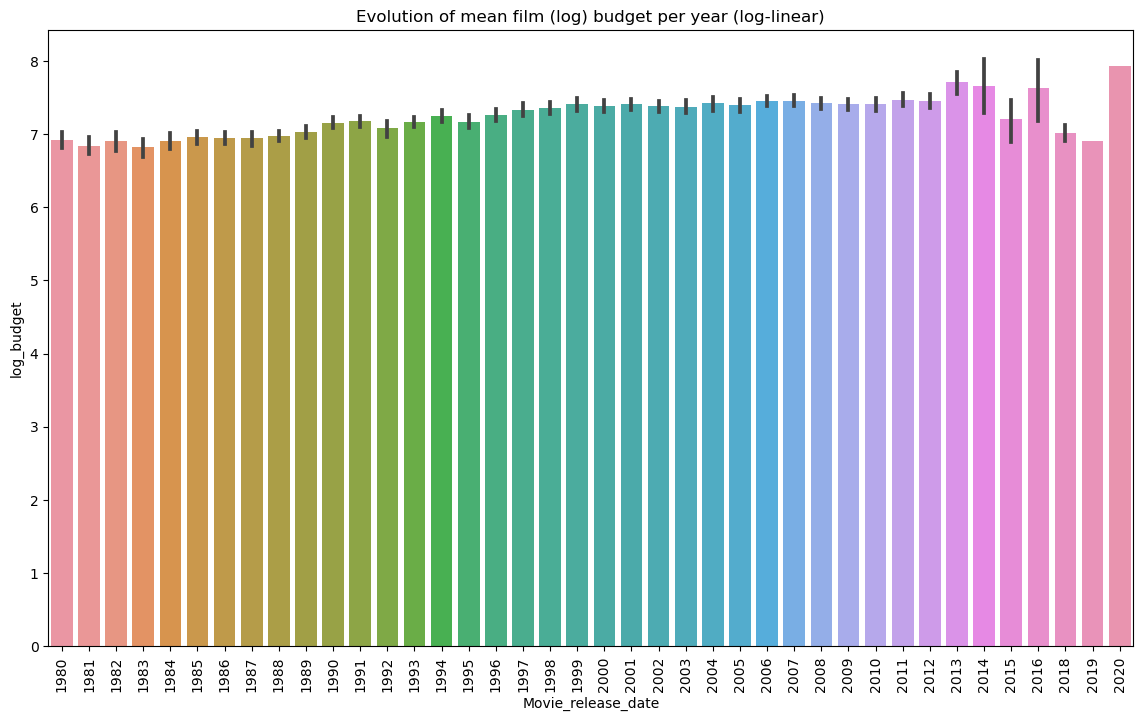

In [272]:
fig,ax = plt.subplots(figsize=(14,8))
sns.barplot(data = df_all, x='Movie_release_date', y='log_budget',estimator='mean', ax=ax)
plt.xticks(rotation=90)
plt.title('Evolution of mean film (log) budget per year (log-linear)')

In [273]:
print('Mean of log_budget:',df_all.log_budget.mean())
print('Std in budget: {v1:.2f} and in log_budget: {v2:.2f}'.format(v1=df_all.budget.std(),v2=df_all.log_budget.std()))

Mean of log_budget: 7.269570285750702
Std in budget: 37088535.03 and in log_budget: 0.55


Text(0.5, 1.0, 'Evolution of log budget')

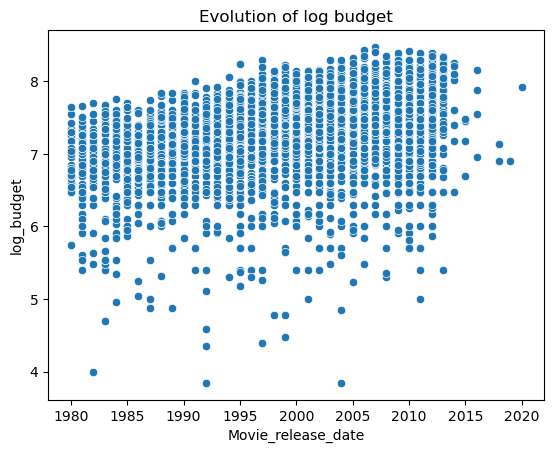

In [22]:
sns.scatterplot(data=df_all, x='Movie_release_date',y='log_budget')
plt.title('Evolution of log budget')

### What about the genres ?

How many movies do we have per genre ?

In [24]:
genres ={}
for i in movies.Movie_genres:
    for j in i:
        if j not in genres:
            genres[j] = 1
        else:
            genres[j]+=1
sorted_genres = sorted(genres.items(), key=lambda x:x[1],reverse=True)
sorted_genres

[('Drama', 4300),
 ('Comedy', 3178),
 ('Romance Film', 2033),
 ('Thriller', 1959),
 ('Action', 1754),
 ('Action/Adventure', 1361),
 ('Crime Fiction', 1279),
 ('Adventure', 1165),
 ('Indie', 1050),
 ('Romantic comedy', 894),
 ('Family Film', 845),
 ('Horror', 772),
 ('Romantic drama', 769),
 ('Fantasy', 702),
 ('Mystery', 681),
 ('Period piece', 669),
 ('Science Fiction', 646),
 ('Film adaptation', 609),
 ('Crime Thriller', 577),
 ('World cinema', 574),
 ('Comedy-drama', 551),
 ('Musical', 541),
 ('War film', 413),
 ('Teen', 401),
 ('Psychological thriller', 398),
 ('Black-and-white', 366),
 ('Coming of age', 351),
 ('Black comedy', 350),
 ('Animation', 331),
 ('Parody', 320),
 ('Cult', 316),
 ('Sports', 308),
 ("Children's/Family", 291),
 ('Biography', 286),
 ('LGBT', 279),
 ('Family Drama', 272),
 ('Suspense', 271),
 ('Western', 270),
 ('Biographical film', 255),
 ('Buddy film', 221),
 ('Costume drama', 219),
 ('Slapstick', 214),
 ('Satire', 199),
 ('Slasher', 192),
 ('Supernatural', 

In [25]:
# Count the revenue per genre
main_genres = [elt[0] for elt in sorted_genres[:25]] # Completely arbitrary choice of the number of genres to keep
revenue_per_genre = {}
for genre in main_genres: # iteration over the main genres
    count = 0
    revenues = []
    for index,row in movies.iterrows(): # iteration over the movies
        if genre in row.Movie_genres: # if the movie contains the genre
            revenues.append(row.Movie_box_office_revenue) # add the revenue of the movie
    revenue_per_genre[genre] = sorted(revenues)[int(len(revenues)/2)] # take the median revenue per genre

In [28]:
# conversion to dataframe
df_revenue_per_genre = pd.DataFrame.from_dict(revenue_per_genre, orient ='index')
df_revenue_per_genre.rename(columns={0:'Revenue'},inplace=True)
#df_revenue_per_genre.sort_values(by='Revenue',inplace=True,ascending=False) # uncomment to sort by revenue

Text(0.5, 0, 'Main genres (by decreasing order of popularity)')

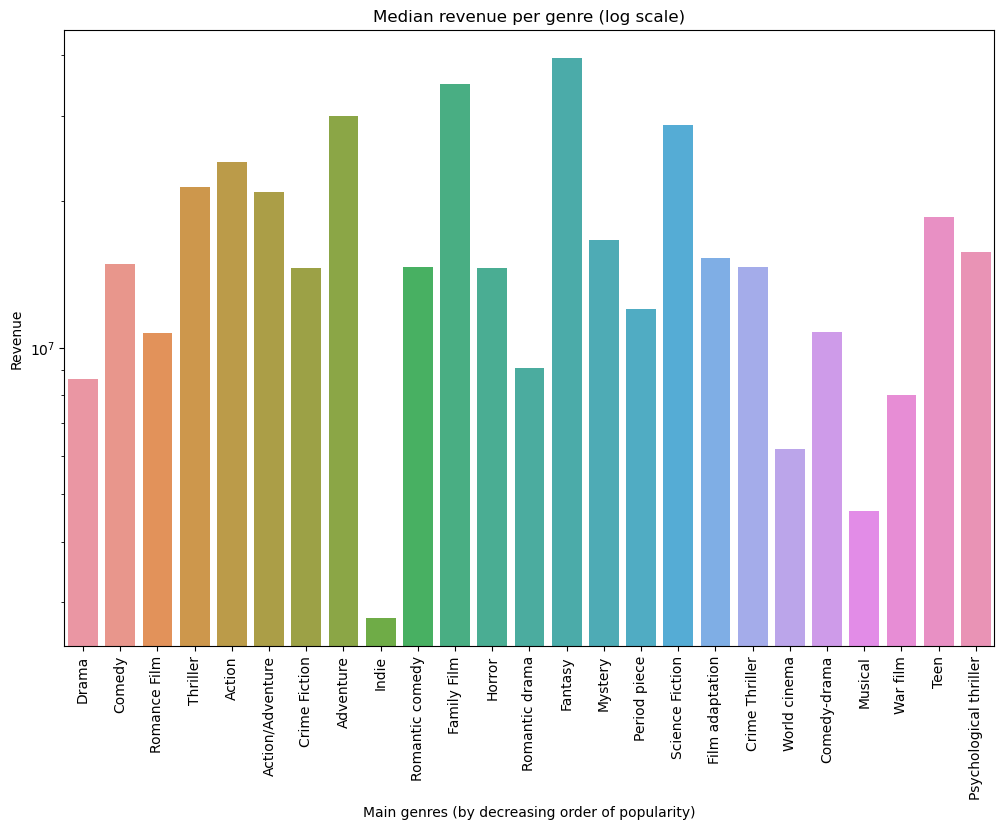

In [29]:
fig,ax = plt.subplots(figsize=(12,8))
sns.barplot(df_revenue_per_genre,x=df_revenue_per_genre.index,y='Revenue')
plt.xticks(rotation=90)
plt.yscale('log')
plt.title('Median revenue per genre (log scale)')
plt.xlabel('Main genres (by decreasing order of popularity)')

We can see that the number of films per genre do not seem to be correlated with the revenue of the film. But to be conclusive we will have to be careful about the number of genres per film (e.g if 'Drama' is always cited as a genre with 4 other genres, then the film might not be a pure Drama), and other counfounders.

Now let us have a look at the characters dataset.

## Characters

In [30]:
characters.head()

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_release_date,Character_name,Actor_date_of_birth,Actor_gender,Actor_height_meters,Actor_ethnicity_Freebase_ID,Actor_name,Actor_age_at_movie_release,Freebase_character_actor_map_ID,Freebase_character_ID,Freebase_actor_ID
1,975900,/m/03vyhn,2001.0,Lieutenant Melanie Ballard,1974.0,F,1.78,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001.0,Desolation Williams,1969.0,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
5,975900,/m/03vyhn,2001.0,Commander Helena Braddock,1949.0,F,1.727,/m/0x67,Pam Grier,52.0,/m/02vdcfp,/m/0bgchnd,/m/0418ft
56,2314463,/m/0734w5,2006.0,Taper Guy,1971.0,M,1.87,/m/033tf_,Matt Stone,34.0,/m/0cgn0lx,/m/0h0z488,/m/01_x6d
76,612710,/m/02wjqm,1999.0,Sandii,1975.0,F,1.68,/m/0222qb,Asia Argento,24.0,/m/02vcxk_,/m/0h2l6rx,/m/028pzq


### About the numbers

How many films per actor...

Text(0, 0.5, 'Cout of such actors (log-linear)')

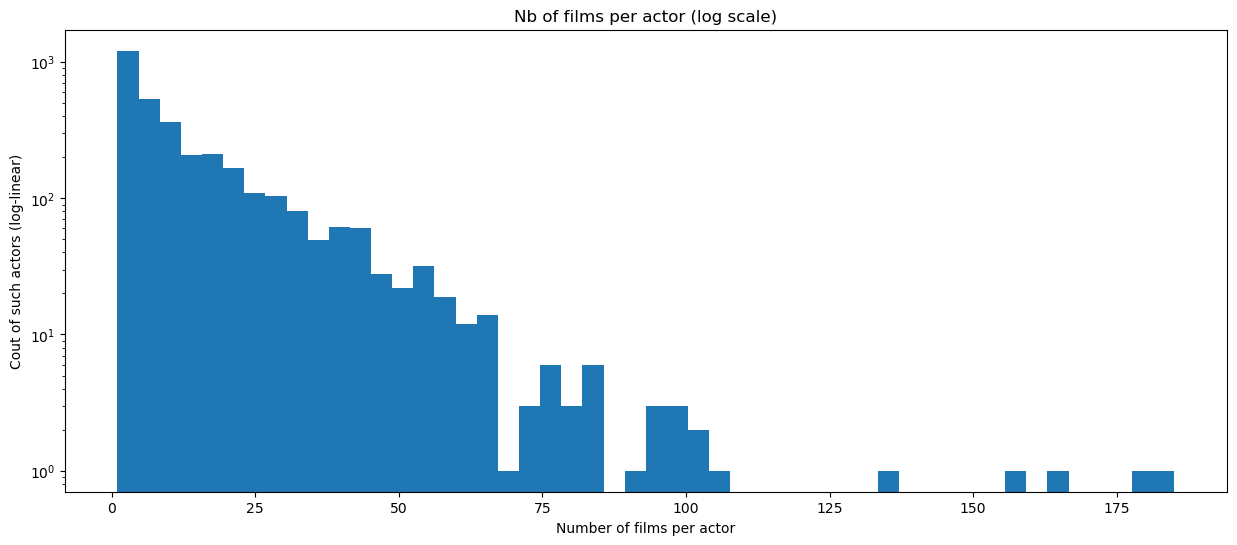

In [31]:
characters_per_actor = characters.groupby('Actor_name')
fig,ax = plt.subplots(figsize=(15,6))
plt.hist(characters_per_actor.agg('count').Wikipedia_movie_ID,bins=50)
ax.set(yscale='log')
plt.title('Nb of films per actor (log scale)')
plt.xlabel('Number of films per actor')
plt.ylabel('Cout of such actors (log-linear)')

... and how many characters per film (which can reasonably be assumed equal to the number of actors in the general case)

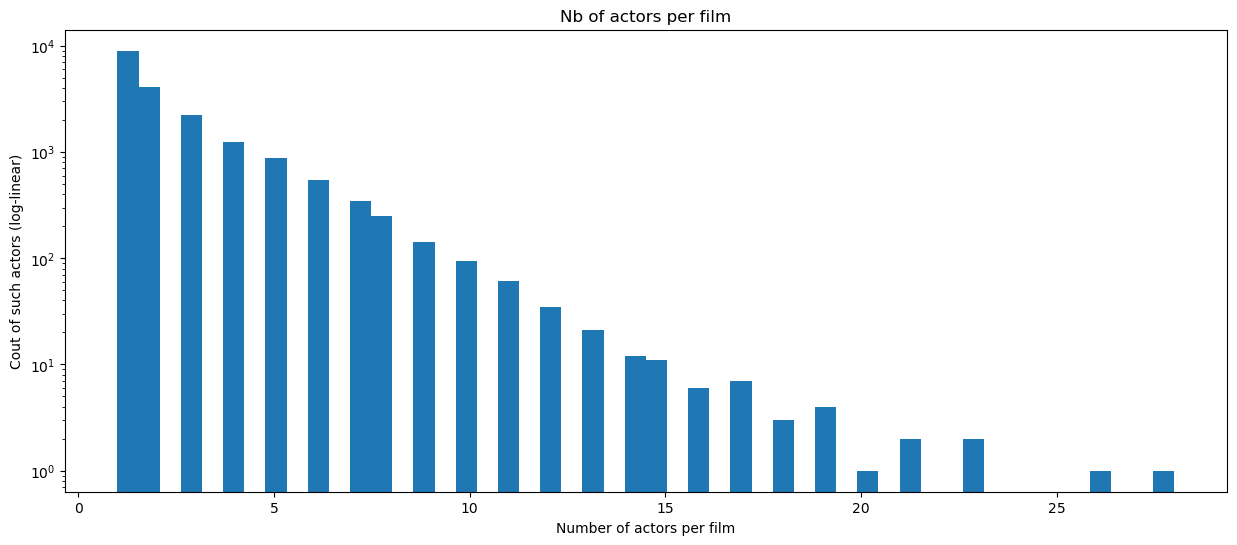

In [32]:
characters_per_film = characters.groupby('Wikipedia_movie_ID')
fig,ax = plt.subplots(figsize=(15,6))
plt.hist(characters_per_film.agg('count').Freebase_actor_ID,bins=50)
ax.set(yscale='log')
plt.title('Nb of actors per film')
plt.xlabel('Number of actors per film')
plt.ylabel('Cout of such actors (log-linear)')
None

A beautiful power-law, which tells us that only the major characters are registered in the database for the majority of films, and that the majority of actors in the database play a role only in a few films.

### Some evolutions

Conversion of gender to {0,1} (0 for male, 1 for female).

In [33]:
characters.Actor_gender = (characters.Actor_gender=='F').apply(int)
characters.head()

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_release_date,Character_name,Actor_date_of_birth,Actor_gender,Actor_height_meters,Actor_ethnicity_Freebase_ID,Actor_name,Actor_age_at_movie_release,Freebase_character_actor_map_ID,Freebase_character_ID,Freebase_actor_ID
1,975900,/m/03vyhn,2001.0,Lieutenant Melanie Ballard,1974.0,1,1.78,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001.0,Desolation Williams,1969.0,0,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
5,975900,/m/03vyhn,2001.0,Commander Helena Braddock,1949.0,1,1.727,/m/0x67,Pam Grier,52.0,/m/02vdcfp,/m/0bgchnd,/m/0418ft
56,2314463,/m/0734w5,2006.0,Taper Guy,1971.0,0,1.87,/m/033tf_,Matt Stone,34.0,/m/0cgn0lx,/m/0h0z488,/m/01_x6d
76,612710,/m/02wjqm,1999.0,Sandii,1975.0,1,1.68,/m/0222qb,Asia Argento,24.0,/m/02vcxk_,/m/0h2l6rx,/m/028pzq


Text(0, 0.5, 'Proportion of female in the film')

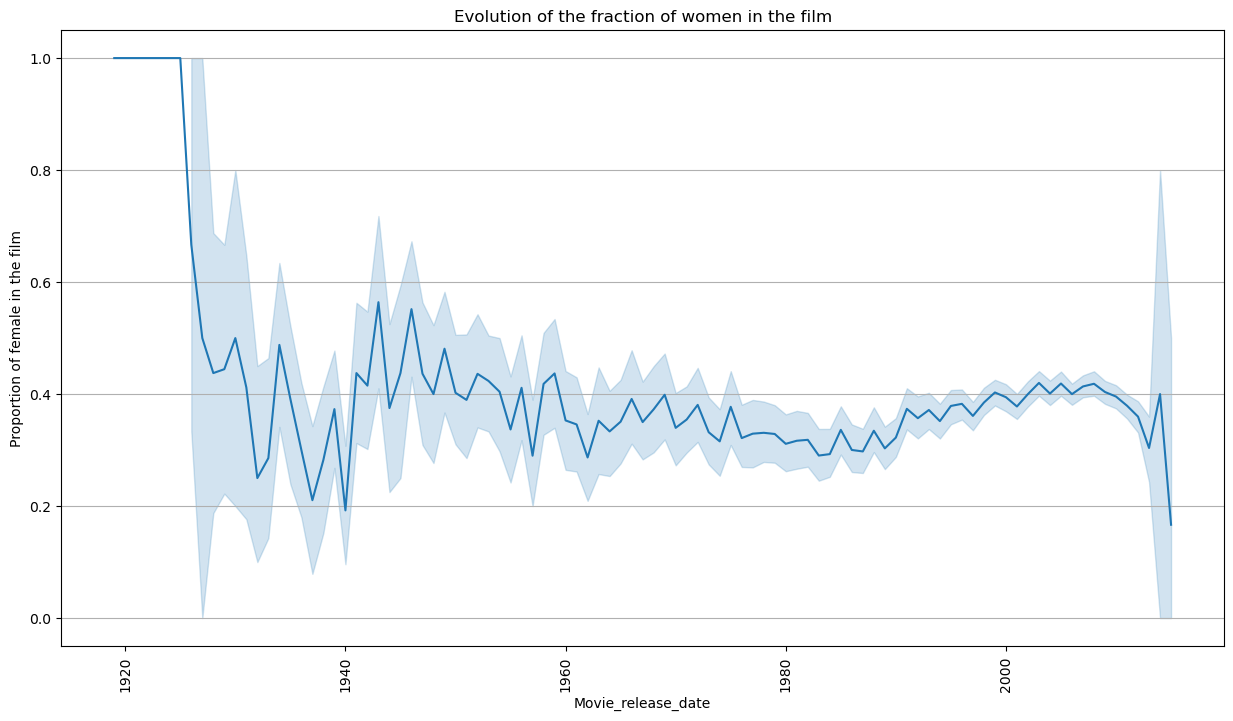

In [36]:
fig,ax = plt.subplots(figsize=(15,8))
sns.lineplot(data = characters, x=characters.Movie_release_date, estimator='mean', y='Actor_gender', ax=ax)
plt.grid(visible=True, axis='y')
plt.xticks(rotation=90)
plt.title('Evolution of the fraction of women in the film')
plt.ylabel('Proportion of female in the film')

About the age of actors

Text(0.5, 1.0, 'Evolution of median age of the actor (1=female)')

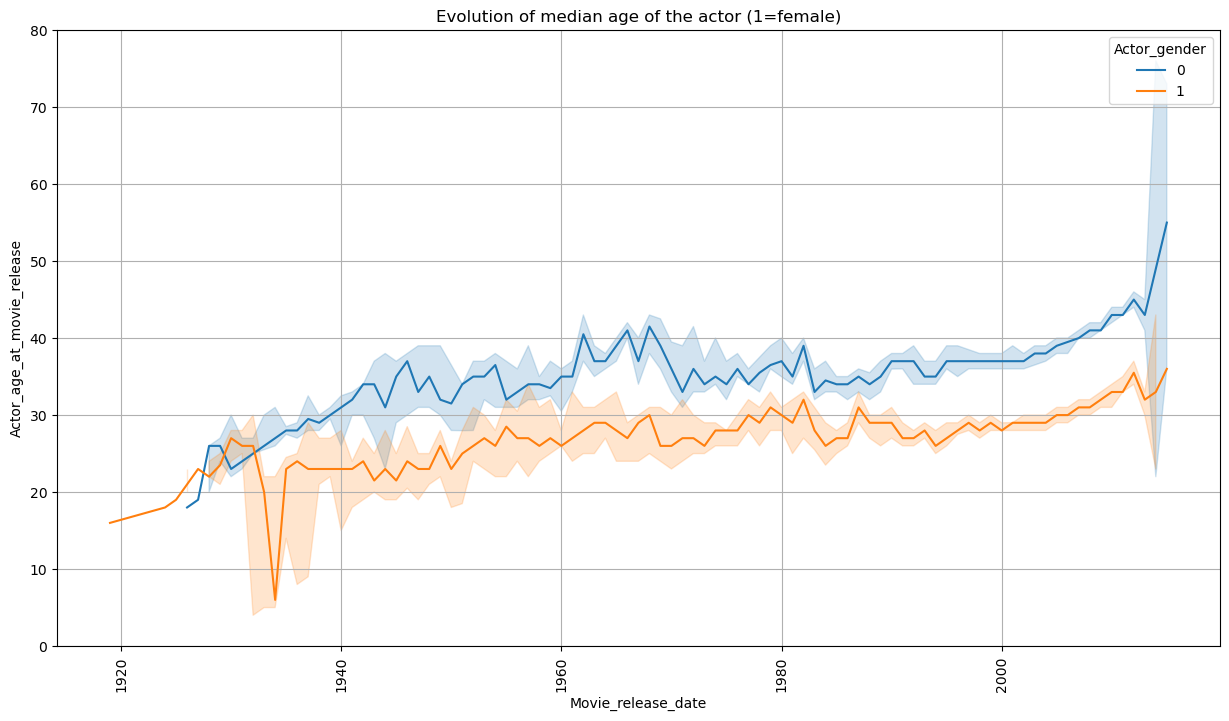

In [448]:
fig, ax = plt.subplots(figsize=(15,8))
sns.lineplot(data = characters, x=characters.Movie_release_date, y='Actor_age_at_movie_release',hue='Actor_gender',estimator='median', ax=ax)
plt.grid(visible=True)
plt.xticks(rotation=90)
plt.ylim(0,80)
plt.title('Evolution of median age of the actor (1=female)')

# Data analysis
Let us dive into the analysis part. From now on, we will mainly use the merged datasets (`df_all`), corresponding to a merging between CMU, IMDb and so-called movie-stats datasets.

## Some useful regressions and correlations

We will first study some regressions and correlations which will be useful later.

### Revenue = f(t)

We compute the coefficient of the regression for the mean log-revenue (i.e the log of the geometric mean of revenue) in function of the release year. This allows us to have a rough estimate of the **annual augmentation of movie revenues**.

In [49]:
to_plot = df_all
to_plot = to_plot[['log_revenue','Movie_release_date']].groupby(to_plot.Movie_release_date,as_index=False).agg('mean')
mod = smf.ols(formula='log_revenue ~ Movie_release_date',data=to_plot)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            log_revenue   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     3.517
Date:                Thu, 22 Dec 2022   Prob (F-statistic):             0.0684
Time:                        11:20:59   Log-Likelihood:                -28.301
No. Observations:                  40   AIC:                             60.60
Df Residuals:                      38   BIC:                             63.98
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            -18.2179     13

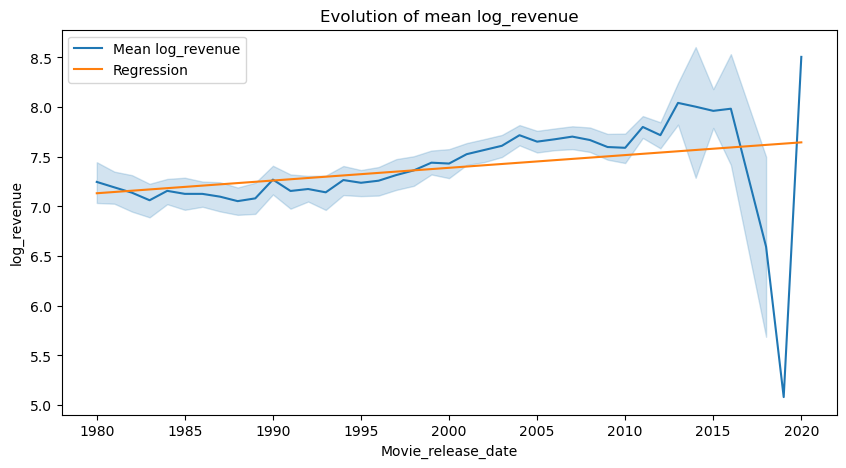

In [51]:
fig,ax = plt.subplots(figsize=(10,5))
sns.lineplot(data = df_all, x='Movie_release_date', y='log_revenue', ax=ax,label='Mean log_revenue')
sns.lineplot(data = to_plot, x='Movie_release_date', y=res.params.Intercept+res.params.Movie_release_date*to_plot.Movie_release_date, ax=ax,label='Regression')
plt.title('Evolution of mean log_revenue')
plt.legend()

In [52]:
rate_revenue = 10**res.params.Movie_release_date-1
print('Annual augmentation of the revenue: {r:.2f}%'.format(r=rate_revenue*100))

Annual augmentation of the revenue: 2.99%


### Revenue = f(budget)

In [366]:
print('Correlation Revenue VS budget: %.2f'%df_all.Movie_box_office_revenue.corr(df_all.budget))
print('Correlation log_revenue VS log_budget: %.2f'%df_all.log_revenue.corr(df_all.log_budget))

Correlation Revenue VS budget: 0.70
Correlation log_revenue VS log_budget: 0.64


The correlations suggests that the budget is an important factor in the movie revenues, and should be considered as a major counfounder/predictor in our study.

Let us see a regression $\text{log_revenue} = \beta_0 + \beta_1 \text{log_budget}$.

In [56]:
mod = smf.ols(formula='log_revenue ~ log_budget',data=df_all)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            log_revenue   R-squared:                       0.409
Model:                            OLS   Adj. R-squared:                  0.408
Method:                 Least Squares   F-statistic:                     2828.
Date:                Thu, 22 Dec 2022   Prob (F-statistic):               0.00
Time:                        11:32:25   Log-Likelihood:                -3906.2
No. Observations:                4096   AIC:                             7816.
Df Residuals:                    4094   BIC:                             7829.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3492      0.133      2.619      0.0

<AxesSubplot:xlabel='log_budget', ylabel='log_revenue'>

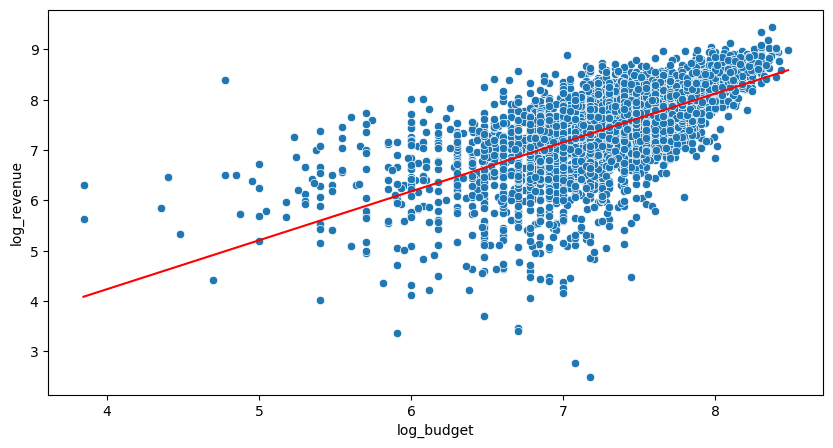

In [57]:
fig,ax = plt.subplots(figsize=(10,5))
sns.scatterplot(data = df_all, x='log_budget', y='log_revenue', ax=ax)
sns.lineplot(data = df_all, x='log_budget', y=res.params.Intercept+res.params.log_budget*df_all.log_budget, ax=ax,color='r')

Even if there is still a lot of unexplained variance around the regression line, this very simple model very wall captures the linear relationship between revenue and budget.

An increase of the budget of 10% ($+\log_{10}(1.1)$) will result in an increase of revenue of 10.3% ($=10^{0.97}\times 1.1$).

### Revenue = f(t,budget)

We try to combine both effects (evolution and budget) with the following $\text{log_revenue} = \beta_0 + \beta_1 \text{log_budget} + \beta_2 \text{Movie_release_date} + \beta_3 \text{Movie_release_date} \cdot \text{log_budget}$.

In [53]:
mod = smf.ols(formula='log_revenue ~ log_budget*Movie_release_date',data=df_all)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            log_revenue   R-squared:                       0.422
Model:                            OLS   Adj. R-squared:                  0.421
Method:                 Least Squares   F-statistic:                     994.4
Date:                Thu, 22 Dec 2022   Prob (F-statistic):               0.00
Time:                        11:27:44   Log-Likelihood:                -3860.4
No. Observations:                4096   AIC:                             7729.
Df Residuals:                    4092   BIC:                             7754.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

In order to have an easier interpretation, we should have normalized our data. As this regression is not the center of our work, we are just interested in the qualitative interpretation.

For a fixed year $y$ (1980 for the example), an augmentation of 10% of the budget ($+\log_{10}(1.1)$) will result in an augmentation of $10^{-32.57} \times 1.1 \times 10^{0.0168 \times y} \times 1.1 \%$ ($=5.43\%$ for the example). This gives an interesting view of how much you should invest in a film to obtain a given revenue, at a given year.

## Question 1

Our purppose here is to study the gender in the movies. More particularly, how diverse are the actors genders in movies? How has this evolved over time? Does it change depending on genre? Movie language/place?

These questions will be answered using the CMU dataset, as we are mainly focusing on qualitative observations, and trends more that quantitative results.

## New dataframe

To answer all these questions, we count the number of female/male per film

In [61]:
# Group by film (wiki id)
grouped = characters[['Wikipedia_movie_ID','Actor_gender']].groupby(characters.Wikipedia_movie_ID)
# count nb of actor for each gender
df_gender = grouped.agg('sum')
df_gender['nb_m'] = grouped['Actor_gender'].agg('count').values - grouped['Actor_gender'].agg('sum').values
df_gender.rename(columns = {'Actor_gender':'nb_f'}, inplace = True)
# compute the percentage of female actress for each film
df_gender['ratio'] = df_gender['nb_f']/(df_gender['nb_f']+df_gender['nb_m'])*100
df_gender.head()

,nb_f,nb_m,ratio
Wikipedia_movie_ID,,,
3217,2,0,100.000000
3746,0,3,0.000000
3837,1,5,16.666667
4227,0,1,0.000000
4231,3,5,37.500000


## Part of women in films over time

In [62]:
global_mean = df_gender.ratio.mean()
print('In average, percentage of women in the films of the dataset: {p:.2f}%'.format(p=global_mean))

In average, percentage of women in the films of the dataset: 39.33%


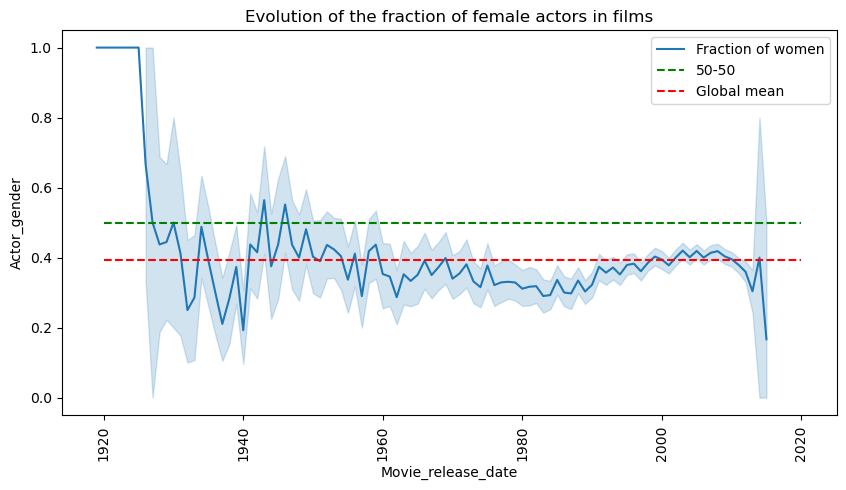

In [70]:
fig,ax = plt.subplots(figsize=(10,5))
sns.lineplot(data = characters, x=characters.Movie_release_date, y='Actor_gender', ax=ax,label='Fraction of women')
plt.hlines(0.5,1920,2020,color='green',linestyle='--',label='50-50')
plt.hlines(global_mean/100,1920,2020,color='red',linestyle='--',label='Global mean')
#plt.grid(visible=True, axis='y')
plt.xticks(rotation=90)
plt.title('Evolution of the fraction of female actors in films')
plt.legend()

We can see that the percentage of female actress is relatively constant, if we don't look at the extremal release dates on which we don't have enough data.

The global mean (which was computed taking into account all the dates, but should not be strongly influenced by extremal dates given the low number of datapoints) was estimated just below 40%.

## Women in films per genre

But we can reasonably expect that the fraction of women in films highly depends on the genre (more female are expected in Romantic comedy than in War films for instance).

Therefore we will study the percentage of female actress per genre.

In [75]:
# dictionnary computing the number of female and male actors for each gender
gender_per_genre ={}
# iteration over the films
for idx,row in movies.iterrows():
    # get list of genres of the film
    genre_list = row.Movie_genres
    # if the film is in df_gender, get the nb of female and male actors
    try:
        nb_f,nb_m = df_gender.loc[row.Wikipedia_movie_ID,'nb_f'],df_gender.loc[row.Wikipedia_movie_ID,'nb_m']
    except KeyError:
        continue
    # for each genre of the film
    for g in genre_list:
        # update the dictionnary
        if g not in gender_per_genre:
            gender_per_genre[g] = [nb_m,nb_f]
        else:
            gender_per_genre[g][0] += nb_m
            gender_per_genre[g][1] += nb_f

# put this into a dataframe
df_gender_per_genre = pd.DataFrame.from_dict(gender_per_genre,orient='index')
df_gender_per_genre.rename(columns={0:'nb_m',1:'nb_f'},inplace=True) # rename the columns
df_gender_per_genre['ratio'] = df_gender_per_genre['nb_f']/(df_gender_per_genre['nb_m']+df_gender_per_genre['nb_f'])*100 # compute the percentage
df_gender_per_genre.sort_values(by='ratio',inplace=True,ascending=False) # sort by percentage of females

# Select only if there are enough actors, approximately equivalent to enough films in the genre
df_gender_per_genre_lim = df_gender_per_genre[df_gender_per_genre['nb_m']+df_gender_per_genre['nb_f'] >= 800]
df_gender_per_genre_lim.head(4)

,nb_m,nb_f,ratio
Romantic comedy,1571,1298,45.242245
Romantic drama,1074,874,44.866530
Comedy-drama,1072,815,43.190249
Romance Film,3227,2446,43.116517


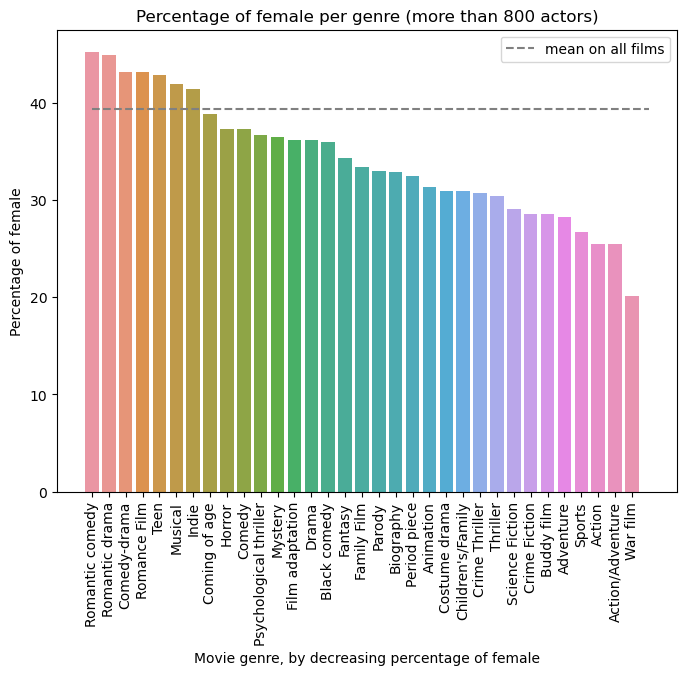

In [81]:
fig,ax = plt.subplots(figsize=(8,6))
sns.barplot(data=df_gender_per_genre_lim, x=df_gender_per_genre_lim.index, y='ratio')
plt.hlines(global_mean,0,len(df_gender_per_genre_lim.index),linestyle='--',color='grey',label='mean on all films')
plt.xticks(rotation=90)
plt.title('Percentage of female per genre (more than 800 actors)')
plt.ylabel('Percentage of female')
plt.xlabel('Movie genre, by decreasing percentage of female')
plt.legend()

And for the 5 main genres:

In [82]:
N = 5
for elt in sorted_genres[:N]:
    print('{genre} ({nb} films): {ratio:.1f}% of females'.format(genre=elt[0],nb=elt[1],ratio = df_gender_per_genre.loc[elt[0],'ratio']))

Drama (4300 films): 36.1% of females
Comedy (3178 films): 37.3% of females
Romance Film (2033 films): 43.1% of females
Thriller (1959 films): 30.4% of females
Action (1754 films): 25.5% of females


Indeed, we can clearly see the expected variation, and we will take into account that the film genre is a potentiel big confounder for our gender study.

## Women in films per language/location

Seeing such inequalities among the movies genres triggered our attention, and we searched other factors of inequalities.
Hence the question "Are their more inequalities in some countries or for some languages?"

Note here the term inequality simply stands for "unbalanced".

In [87]:
# Same structure than women per genre
gender_per_country ={}
film_per_country = {}
gender_per_language = {}
film_per_language = {}
for idx,row in movies.iterrows():
    countries = row.Movie_countries
    languages = row.Movie_languages
    
    # Recover the number of females/males for the film
    try:
        nb_f,nb_m = df_gender.loc[row.Wikipedia_movie_ID,'nb_f'],df_gender.loc[row.Wikipedia_movie_ID,'nb_m']
    except KeyError:
        continue
    
    # Update the countries
    for country in countries:
        if country not in gender_per_country:
            gender_per_country[country] = [nb_m,nb_f]
            film_per_country[country] = 1
        else:
            gender_per_country[country][0] += nb_m
            gender_per_country[country][1] += nb_f
            film_per_country[country] += 1
            
    # Update the languages     
    for l in languages:
        if l not in gender_per_language:
            gender_per_language[l] = [nb_m,nb_f]
            film_per_language[l] = 1
        else:
            gender_per_language[l][0] += nb_m
            gender_per_language[l][1] += nb_f
            film_per_language[l] += 1

# Convert the dictionnaries to dataframes, and compute the percentage of female actress
gender_per_country = pd.DataFrame.from_dict(gender_per_country,orient='index')
gender_per_country['ratio'] = gender_per_country[1]/(gender_per_country[0]+gender_per_country[1])*100
gender_per_country.sort_values(by='ratio',inplace=True,ascending=False)
gender_per_country_lim = gender_per_country[gender_per_country[0]+gender_per_country[1] >= 50]

gender_per_language = pd.DataFrame.from_dict(gender_per_language,orient='index')
gender_per_language['ratio'] = gender_per_language[1]/(gender_per_language[0]+gender_per_language[1])*100
gender_per_language.sort_values(by='ratio',inplace=True,ascending=False)
gender_per_language_lim = gender_per_language[gender_per_language[0]+gender_per_language[1] >= 50]

# Sort the counts for countries and languages
film_per_country = {key: val for key, val in sorted(film_per_country.items(), key = lambda ele: ele[1], reverse=True)}
film_per_language = {key: val for key, val in sorted(film_per_language.items(), key = lambda ele: ele[1], reverse=True)}

First, let us see the countries

In [88]:
gender_per_country_lim.head(5)

,0,1,ratio
Mexico,32,27,45.762712
South Korea,63,48,43.243243
Spain,135,89,39.732143
Italy,228,149,39.522546
Canada,560,351,38.529089


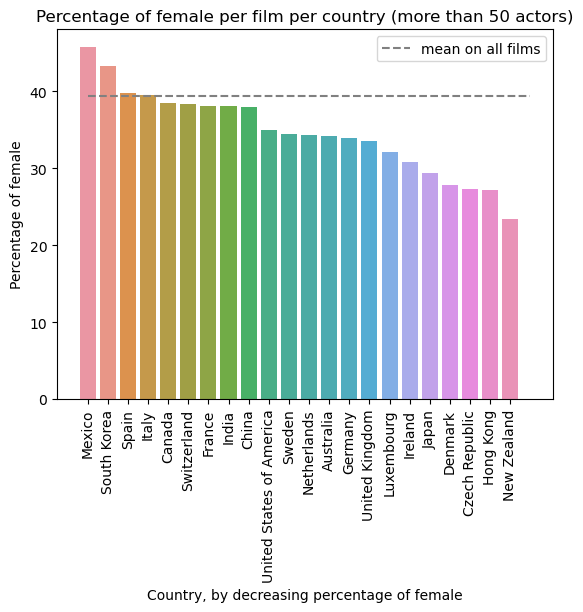

In [85]:
sns.barplot(data=gender_per_country_lim, x=gender_per_country_lim.index, y='ratio')
plt.hlines(global_mean,0,len(gender_per_country_lim.index),linestyle='--',color='grey',label='mean on all films')
plt.xticks(rotation=90)
plt.title('Percentage of female per film per country (more than 50 actors)')
plt.ylabel('Percentage of female')
plt.xlabel('Country, by decreasing percentage of female')
plt.legend()

For the 5 most represented countries (5 countries where there are the most films in our dataset).

In [86]:
N = 5
count = 0
for key,val in film_per_country.items():
    print('{country} ({nb} films): {ratio:.1f}% of females'.format(country=key,nb=val, ratio = gender_per_country.loc[key,'ratio']))
    count += 1
    if count == N:
        break

United States of America (5259 films): 34.9% of females
United Kingdom (794 films): 33.6% of females
Germany (374 films): 34.0% of females
France (364 films): 38.1% of females
Canada (250 films): 38.5% of females


And what about the languages ?

In [89]:
gender_per_language_lim.head()

,0,1,ratio
American English,64,51,44.347826
American Sign Language,33,19,36.538462
Hindi Language,74,42,36.206897
English Language,13663,7302,34.829478
French Language,996,525,34.516765


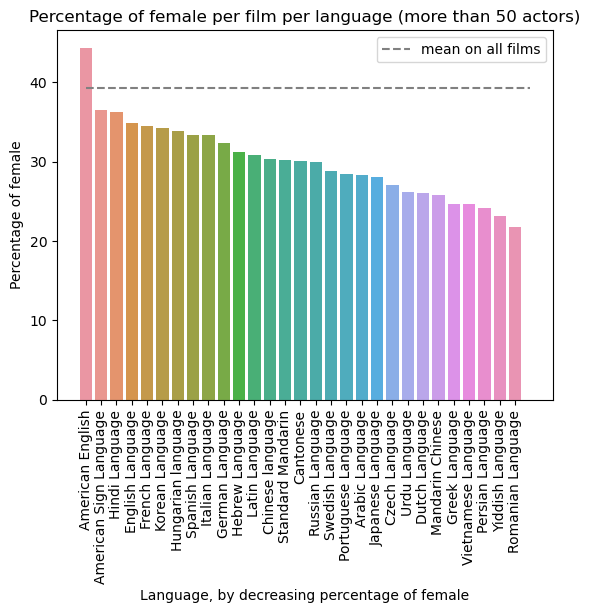

In [90]:
sns.barplot(data=gender_per_language_lim, x=gender_per_language_lim.index, y='ratio')
plt.hlines(global_mean,0,len(gender_per_language_lim.index),linestyle='--',color='grey',label='mean on all films')
plt.xticks(rotation=90)
plt.title('Percentage of female per film per language (more than 50 actors)')
plt.ylabel('Percentage of female')
plt.xlabel('Language, by decreasing percentage of female')
plt.legend()

For the 5 most represented languages (5 languages where there are the most films).

In [91]:
N = 5
count = 0
for key,val in film_per_language.items():
    print('{language} ({nb} films): {ratio:.1f}% of females'.format(language=key,nb=val, ratio = gender_per_language_lim.loc[key,'ratio']))
    count += 1
    if count == N:
        break

English Language (5603 films): 34.8% of females
French Language (387 films): 34.5% of females
Spanish Language (358 films): 33.4% of females
German Language (211 films): 32.4% of females
Italian Language (192 films): 33.4% of females


This study by country and language was super useful, as it showed that our dataset is clearly biased! Indeed, there are much more american (USA) films, in English (or American English) than other films. 

Concerning the potential inequalities between countries or languages, we cannot really conclude given the biased mentionned.

### About the definition of success

We could define success as the box office revenue, or the ratings. Let us see the correlations between these two variables.

In [370]:
print('Correlation log_revenue VS Rating: %.2f'%df_all.averageRating.corr(df_all.log_revenue))
print('Correlation Revenue VS Ratings: %.2f'%df_all.averageRating.corr(df_all.Movie_box_office_revenue))

Correlation log_revenue VS Rating: 0.19
Correlation Revenue VS Ratings: 0.23


<AxesSubplot:xlabel='log_revenue', ylabel='averageRating'>

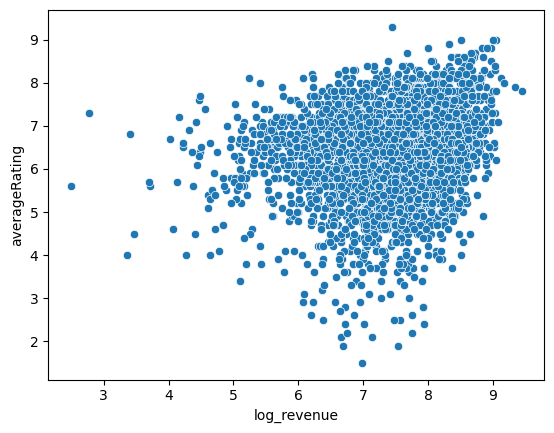

In [371]:
sns.scatterplot(data=df_all, x='log_revenue', y='averageRating')

<AxesSubplot:xlabel='log_budget', ylabel='averageRating'>

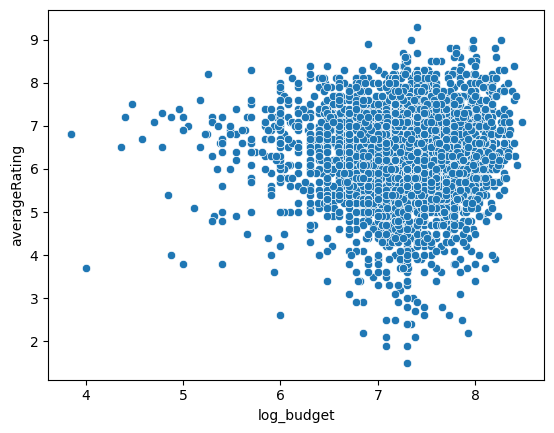

In [372]:
sns.scatterplot(data=df_all, x='log_budget', y='averageRating')

As suggested by the correlation, and confirmed by the plots, the link between revenue and rating or budget and rating is very unclear, and the definition of success is thus very important.

Finally, we could think that we observe a specific rating that is highly biased, or does not correspond to the "true ratings". 

As both IMDb and Stats datasets contain a rating (in `averageRating` for IMDb and `score` for Stats), we can compare these ratings (see below).

We can observe that they have a correlation of 1, despite having "only" 69% of identical ratings. This means that the ratings are not taken from the same source, but agree on their rating as a quality of a film.

In [390]:
print('Correlation Score VS Rating: %.2f'%df_all.averageRating.corr(df_all.score))
print('Percentage of scores equal to rating: %.2f'%((df_all.score == df_all.averageRating).sum()/len(df_all)*100))

Correlation Score VS Rating: 1.00
Percentage of scores equal to rating: 68.95


## Women in films according to the success

### Success = revenue

We want to test the hypothesis that the percentage of women playing a role in a film has an impact on the revenue of the film (positive or negative, to see).

List of potential counfounders that can impact the revenue of a movie:
- Release year
- Genre of the film
- Countries where the film is seen -- Languages of the film
- budhet of the film

As we have many countries which are not represented equally, we will first study our hypothesis for films in the USA, with English language ($\approx 5000$ films).

We will create two groups (low and high still to be defined):
- control group: films with "low" percentage of women
- treated group: films with "high" percentage of women

We will match films from each group to create pairs of films that have similar release year, similar genres and similar budgets (similar still to be defined).

Then, we will compare the revenue in the two groups.

Confounders/effects not taken into account:
- the evolution of this potential impact (maybe before 1968 there was a positive impact, and now a negative one for instance): we assume the effect does not evolve.
- is our dataset representing of the true distribution of films characteristics (genres, nb films per year,...) ? We assume that yes, it is.

**Definitions**:
- Definition of distance between film 1 $f_1$ and film 2 $f_2$ (see below for the justification):
$$
    \text{distance}(f_1,f_2) = (\text{year}_1 - \text{year}_2)^2 + \left(\frac{\min\left(|\text{genres}_1|,|\text{genres}_2|\right)}{|\text{genres}_1 \cap \text{genres}_2|}-1 \right)^2 + 
    2(\log(\text{budget}_1) - \log(\text{budget}_2))^2
$$
- Definition of low (L) and high (H) percentage of women (percentage female):
$$
    f \in L \iff \text{percentage female} \leq (\text{global mean} - \epsilon) \text{ and } (\text{nb actors}  \geq N) \\
    f \in H \iff \text{percentage female} \geq (\text{global mean} + \epsilon) \text{ and } (\text{nb actors}  \geq N)
$$
where, $\epsilon = 10\%$ and $N=3$.

Some tests to build the distance metric

In [307]:
print('Mean nb of genres length: {m:.2f} \nStd dev of genres length: {s:.2f}'.format(m=movies.Movie_genres.apply(len).mean(),s=movies.Movie_genres.apply(len).std()))

Mean nb of genres length: 5.08 
Std dev of genres length: 2.43


In [308]:
print('Mean nb of release date: {m:.2f} \nStd dev of release date: {s:.2f}'.format(m=movies.Movie_release_date.mean(),s=movies.Movie_release_date.std()))

Mean nb of release date: 1991.06 
Std dev of release date: 19.73


The first idea is to take the inverse jaccard index.

First focusing on the genre (in parenthesis the results for the next distance choice):
- for two very different films (no common genre), $\frac{|\text{genres}_1 \cup \text{genres}_2|}{|\text{genres}_1 \cap \text{genres}_2|} \approx \frac{|\text{genres}_1 \cup \text{genres}_2|}{0} + \infty \ (+\infty)$
- for two quite different films (1 common genre), $\frac{|\text{genres}_1 \cup \text{genres}_2|}{|\text{genres}_1 \cap \text{genres}_2|} \approx \frac{5+5-1}{1} \approx 9 \ (5)$
- for two quite similar films (3 common genres), $\frac{|\text{genres}_1 \cup \text{genres}_2|}{|\text{genres}_1 \cap \text{genres}_2|} \approx \frac{5+5-3}{3} \approx 2.33 \ (1.66)$
- for two very similar films (same genres) $\frac{|\text{genres}_1 \cup \text{genres}_2|}{|\text{genres}_1 \cap \text{genres}_2|} \approx \frac{5+5-5}{5} = 1 \ (1)$

This function seems to work well to identify distance in genres if there are the same number of genres.

But if there are different lengths of genres, for very "unbalanced" and similar films, $\frac{|\text{genres}_1 \cup \text{genres}_2|}{|\text{genres}_1 \cap \text{genres}_2|} \approx \frac{7+1-1}{1} = 7$, which is the score for quite different films.

Hence we search a correction term $f(x,y)$ with the following properties ($x$ and $y$ are sets):
- $f(x,x) \approx 1$ (no change of scale for equal lengths)
- $f(x,y) = f(y,x)$ (symmetry)
- $|x| << |y|$ and $x \subset y \implies f(x,y) \approx \frac{|x|}{|y|}<<1$ (unbalanced but similar)
- $|x| << |y|$ and $|x \cap y| \approx 0  \implies f(x,y) >> 1$ or $\approx 1$ (unbalanced but different)

We choose $f(x,y) = \frac{\min\left(|x|,|y|\right)}{|x \cup y|}$ which satisfies the above properties.

Our new distance is now $\frac{\min\left(|x|,|y|\right)}{|x \cap y|}$. The results for balanced lengths are shown in parenthesis.

But now, for very "unbalanced" and similar films (7 genres VS 1 genre, 1 common), we obtain $\approx \frac{1}{1} = 1$, which is the same for very similar "balanced" films.

And for very "unbalanced" and different films (10 genres VS 3, 1 common), we obtain $\approx \frac{3}{1} = 3$, which is between similar and different films.

We have a pretty good ordering distance function, now we just need to scale better the differences, by substracting 1 and adding a square. All the results above 2 (in our actual scale) will be pushed further away.


Then, we saw that the movie revenue increased of $\approx 3.29\%$ per year. In order to be able to compare movie revenues, we would like to keep their difference in release date lower than one year, as 3.29% is already a big difference.

Hence our distance in year will be $d(y_1,y_2) = (y_1-y_2)^2$ to put this criterion to the same level as the genre criterion.

Finally, as the standard deviation in log_budget is approximately 0.5 (see above in the jupyter), we decided to include the budget distance as $2(\log(\text{budget}_1) - \log(\text{budget}_2))^2$, to penalize budgets that are too far from each other, but still prioritize the genre distance.

In [309]:
# Seleciton of films in USA in english or american
USA = 'United States of America'
eng = 'English Language'
american = 'American English'
mask = movies.apply(lambda x:USA in x.Movie_countries and (eng in x.Movie_languages or american in x.Movie_languages),axis=1)
id_eng = movies.loc[mask,'Wikipedia_movie_ID'].values
df_gender_eng = df_gender[df_gender.index.isin(id_eng)]

In [310]:
eps = 10
nb_actor = 3
sigma_y = df_all.Movie_release_date.std()
print(len(df_gender_eng[(df_gender_eng.ratio < global_mean-eps)&(df_gender_eng.nb_f + df_gender.nb_m >= nb_actor)]))
print(len(df_gender_eng[(df_gender_eng.ratio > global_mean+eps)&(df_gender_eng.nb_f + df_gender.nb_m >= nb_actor)]))

1240
894


C:\Users\samje\AppData\Local\Temp\ipykernel_3852\2023492664.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(len(df_gender_eng[(df_gender_eng.ratio < global_mean-eps)&(df_gender_eng.nb_f + df_gender.nb_m >= nb_actor)]))
C:\Users\samje\AppData\Local\Temp\ipykernel_3852\2023492664.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(len(df_gender_eng[(df_gender_eng.ratio > global_mean+eps)&(df_gender_eng.nb_f + df_gender.nb_m >= nb_actor)]))


Without matching:

In [431]:
control_df = df_gender_eng[df_gender_eng.ratio < global_mean-eps]
treat_df = df_gender_eng[df_gender_eng.ratio > global_mean+eps]
movies_control = df_all[df_all.Wikipedia_movie_ID.isin(control_df.index)]
movies_treat = df_all[df_all.Wikipedia_movie_ID.isin(treat_df.index)]

# Standrad deviation in log revenue, and log(geometric means)
std_control = movies_control.log_revenue.std()
std_treat = movies_treat.log_revenue.std()
mean_control = movies_control.log_revenue.mean()
mean_treat = movies_treat.log_revenue.mean()

Text(0.5, 0.98, 'Box office revenue (log-scale)')

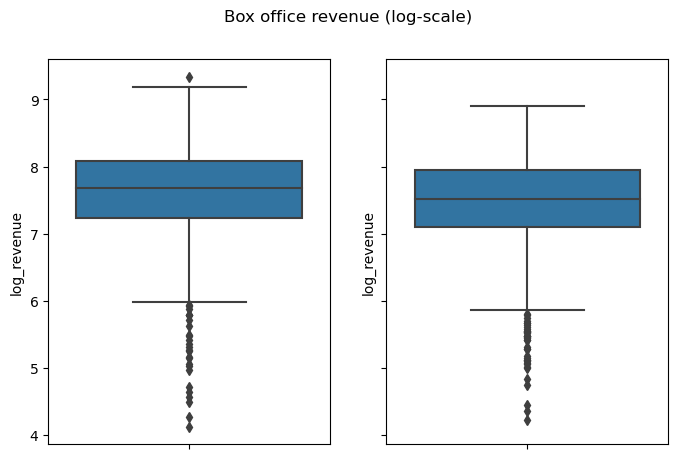

In [432]:
fig,axs = plt.subplots(1,2,figsize=(8,5),sharey=True)
sns.boxplot(data = movies_control, y='log_revenue', ax=axs[0])
sns.boxplot(data = movies_treat, y='log_revenue', ax=axs[1])
#plt.yscale('log')
plt.suptitle('Box office revenue (log-scale)')

Text(0.5, 0.98, 'Median box office revenue')

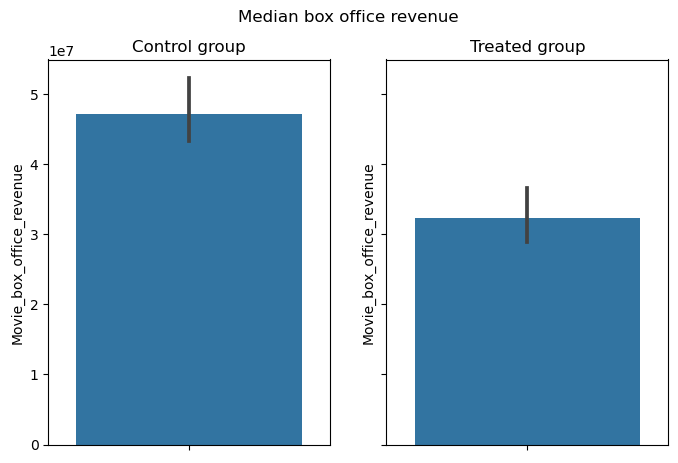

In [433]:
fig,axs = plt.subplots(1,2,figsize=(8,5),sharey=True)
sns.barplot(data = movies_control, y='Movie_box_office_revenue',estimator='median', ax=axs[0])
sns.barplot(data = movies_treat, y='Movie_box_office_revenue',estimator='median', ax=axs[1])
axs[0].set_title('Control group')
axs[1].set_title('Treated group')
#plt.yscale('log')
plt.suptitle('Median box office revenue')

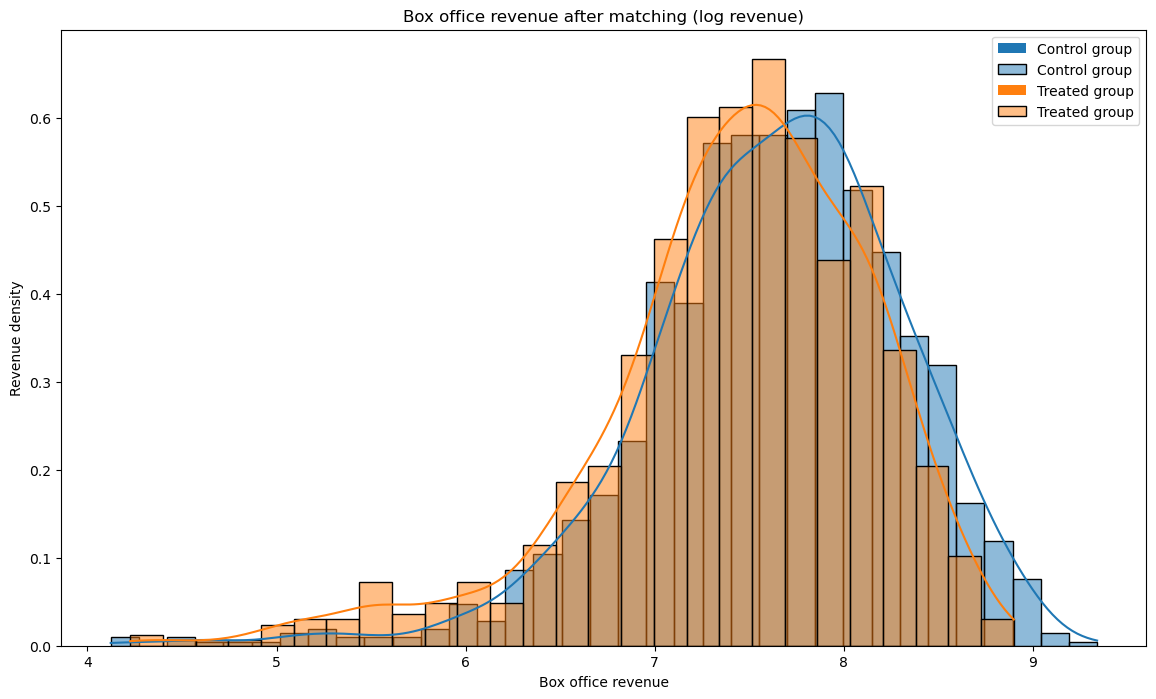

In [434]:
fig,ax = plt.subplots(figsize=(14,8))
sns.histplot(data = movies_control['log_revenue'],kde=True,stat='density', ax=ax,label='Control group')
sns.histplot(data = movies_treat['log_revenue'],kde=True,stat='density', ax=ax,label='Treated group')
ax.set(title='Box office revenue after matching (log revenue)',xlabel='Box office revenue', ylabel='Revenue density')
plt.legend()

We could tend to think that films in which there are less women are more successful (in term of box office revenue).

Matching process

In [341]:
def get_distance(diff_y, genres_1, genres_2, budget_1,budget_2):
    year = diff_y**2
    genres = (min(len(genres_1),len(genres_2))/len(genres_1 & genres_2)-1)**2
    budget = 2*(budget_1-budget_2)**2
    return year + genres + budget

In [348]:
MATCH_DATA = False
if MATCH_DATA:
    from time import time
    # Separate the treatment and control groups
    control_df = df_gender_eng[(df_gender_eng.ratio < global_mean-eps)&(df_gender_eng.nb_f + df_gender_eng.nb_m >= nb_actor)]
    treatment_df = df_gender_eng[(df_gender_eng.ratio > global_mean+eps)&(df_gender_eng.nb_f + df_gender_eng.nb_m >= nb_actor)]

    # Create an empty undirected graph
    G = nx.Graph()

    deb = time()
    count = 0
    # Loop through all the pairs of instances
    for control_idx, control_row in control_df.iterrows():
        # get the matching variables: most time-consuming operation
        try: # try/except to avoid some index error
            y1,b1,genres_1 = df_all[df_all.Wikipedia_movie_ID == control_idx][['Movie_release_date','log_budget','Movie_genres']].values[0]
        except IndexError:
            continue
        # if no genres, pass the film
        if len(genres_1) == 0:
            continue
        
        for treatment_idx, treatment_row in treatment_df.iterrows():
            # get the matching variables: most time-consuming operation
            try:
                y2,b2,genres_2 = df_all[df_all.Wikipedia_movie_ID == treatment_idx][['Movie_release_date','log_budget','Movie_genres']].values[0]
            except IndexError:
                continue
            # do not accept if the diffference of years is to high, to make the algo faster
            diff_y = abs(y2-y1)
            if diff_y > sigma_y:
                continue
            genres_1 = set(genres_1)
            genres_2 = set(genres_2)
            # If no genres or no common genres, pass this film
            if len(genres_2) == 0 or genres_1 & genres_2 == set():
                continue
            
            # compute the distance between the two films
            distance = get_distance(diff_y = diff_y, genres_1=genres_1, genres_2=genres_2,budget_1=b1,budget_2=b2)

            # Add an edge between the two instances weighted by the distance between them
            G.add_weighted_edges_from([(control_idx, treatment_idx, distance)])
        """
        count += 1
        if count == 10:
            break
        """
    print('Temps écoulé:',time()-deb) # 841s
    # Save the graph
    nx.write_gpickle(G, "Data/matching_1.gpickle")

else:
    G = nx.read_gpickle("Data/matching_1.gpickle")

In [349]:
# Find the minimal matching by distance <-> maximal matching by similarity
matching = nx.algorithms.bipartite.matching.minimum_weight_full_matching(G) #(Wiki_id_control, Wiki_id_treat)

C:\Users\samje\anaconda3\lib\site-packages\networkx\algorithms\bipartite\matching.py:569: FutureWarning: biadjacency_matrix will return a scipy.sparse array instead of a matrix in NetworkX 3.0
  weights_sparse = biadjacency_matrix(


In [409]:
# Observe some matchings to check pertinence
count = 0
print('Year / genres / log_10(budget):')
for key,val in matching.items():
    print('---',count,'---')
    print('Control')
    print(*df_all[df_all.Wikipedia_movie_ID == key][['Movie_release_date','Movie_genres','log_budget']].values[0])
    print('Treat')
    print(*df_all[df_all.Wikipedia_movie_ID == val][['Movie_release_date','Movie_genres','log_budget']].values[0])
    count += 1
    if count == 3:
        break

Year / genres / log_10(budget):
--- 0 ---
Control
2008 ['Romantic comedy', 'Romance Film', 'Comedy'] 7.301029995663981
Treat
2008 ['Romantic comedy', 'Romance Film', 'Drama', 'Comedy'] 7.204119982655925
--- 1 ---
Control
1984 ['Crime Fiction', 'Gangster Film', 'Indie', 'Musical', 'Period piece', 'Drama', 'Romantic drama', 'Romance Film', 'Musical Drama'] 7.763427993562937
Treat
1983 ['Musical', 'Feminist Film', 'Drama', 'Romance Film', 'Musical Drama'] 7.079181246047625
--- 2 ---
Control
1997 ['Crime Fiction', 'Thriller', 'Indie', 'Mystery', 'Drama', 'Comedy', 'Crime Thriller', 'Black comedy'] 6.698970004336019
Treat
1997 ['Black comedy', 'Biographical film', 'Biography', 'Drama', 'Comedy'] 7.447158031342219


In [345]:
# Creation of the new dataframe
df_match = df_all[df_all.Wikipedia_movie_ID.isin(list(matching.keys()) + list(matching.values()))]
# annotate control/treated group
for key,val in matching.items():
    df_match.loc[df_match.Wikipedia_movie_ID == key,'group'] = 'control'
    df_match.loc[df_match.Wikipedia_movie_ID == val,'group'] = 'treat'
df_match.head()

C:\Users\samje\AppData\Local\Temp\ipykernel_3852\1617604834.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_match.loc[df_match.Wikipedia_movie_ID == key,'group'] = 'control'


,genre,score,votes,director,writer,star,country,budget,company,Wikipedia_movie_ID,...,tconst,titleType,isAdult,genres,tconstIdentifier,averageRating,numVotes,log_revenue,log_budget,group
76,Comedy,6.9,68000.0,Ivan Reitman,Len Blum,Bill Murray,United States,10000000.0,Columbia Pictures,560511,...,tt0083131,movie,0,"Comedy,War",tt0083131,6.8,74616,7.930934,7.000000,treat
77,Adventure,7.4,59000.0,John Boorman,Thomas Malory,Nigel Terry,United Kingdom,11000000.0,Cinema '84,250699,...,tt0082348,movie,0,"Adventure,Drama,Fantasy",tt0082348,7.3,62537,7.543664,7.041393,treat
79,Action,6.9,42000.0,Desmond Davis,Beverley Cross,Laurence Olivier,United Kingdom,15000000.0,Charles H. Schneer Productions,948548,...,tt0082186,movie,0,"Action,Adventure,Family",tt0082186,6.9,44884,7.612784,7.176091,control
84,Crime,6.6,22000.0,Bob Rafelson,David Mamet,Jack Nicholson,West Germany,12000000.0,CIP Filmproduktion GmbH,5429460,...,tt0082934,movie,0,"Crime,Drama,Romance",tt0082934,6.6,24083,7.086360,7.079181,control
89,Drama,6.8,17000.0,Harold Becker,Darryl Ponicsan,George C. Scott,United States,14000000.0,Major Studio Partners,30863819,...,tt0083169,movie,0,Drama,tt0083169,6.7,18834,7.544108,7.146128,treat


Before analysing the results, we perform some sanity check to ensure our matching did not introduce biases in the dataset between the two groups.

In [346]:
# treated and control dataframes
treat_match = df_match[df_match.group == 'treat']
control_match = df_match[df_match.group == 'control']

# Show some stats
cols = ['Movie_release_date','log_budget','log_revenue','averageRating']
print('-- Treated group --')
print(treat_match[cols].describe())

print('\n-- Control group --')
print(control_match[cols].describe())

-- Treated group --
       Movie_release_date  log_budget  log_revenue  averageRating
count          564.000000  564.000000   564.000000     564.000000
mean          2001.579787    7.483531     7.684539       6.519681
std              6.835469    0.396658     0.662423       0.967309
min           1981.000000    5.397940     4.264086       1.500000
25%           1998.000000    7.301030     7.358674       6.000000
50%           2002.000000    7.477121     7.741139       6.600000
75%           2007.000000    7.763428     8.094861       7.200000
max           2012.000000    8.431364     9.179482       8.700000

-- Control group --
       Movie_release_date  log_budget  log_revenue  averageRating
count          564.000000  564.000000   564.000000     564.000000
mean          2001.569149    7.387723     7.590900       6.197518
std              6.830647    0.400586     0.664400       0.942726
min           1981.000000    5.397940     4.741349       1.900000
25%           1998.000000    7.1686

In [347]:
# INvestigate the repartition of genres
def compute_pop_genres(df,genres_col):
    res = {}
    for idx,row in df.iterrows():
        genres = row[genres_col]
        for g in genres:
            if g not in res:
                res[g] = 1
            else:
                res[g] += 1
    return res

treat_genres = compute_pop_genres(treat_match,'Movie_genres')
control_genres = compute_pop_genres(control_match,'Movie_genres')

treat_genres = sorted(treat_genres.items(), key=lambda x:x[1],reverse=True)
control_genres = sorted(control_genres.items(), key=lambda x:x[1],reverse=True)
df_genres_match = pd.DataFrame(treat_genres,columns=['genre','nb_treat'])

tmp = pd.DataFrame(control_genres,columns=['genre','nb_control'])
df_genres_match = pd.merge(df_genres_match,tmp,on='genre',how='inner')
df_genres_match.sort_values(by='nb_treat',ascending=False,inplace=True)
df_genres_match['percentage_treat'] = df_genres_match.nb_treat/df_genres_match.nb_treat.sum()*100
df_genres_match['percentage_control'] = df_genres_match.nb_control/df_genres_match.nb_control.sum()*100
df_genres_match.head(10)

,genre,nb_treat,nb_control,percentage_treat,percentage_control
0,Drama,305,307,9.256449,9.871383
1,Comedy,275,312,8.345979,10.032154
2,Thriller,201,152,6.100152,4.887460
3,Action,186,81,5.644917,2.604502
4,Crime Fiction,141,69,4.279211,2.218650
5,Romance Film,125,218,3.793627,7.009646
6,Action/Adventure,123,63,3.732929,2.025723
7,Adventure,120,54,3.641882,1.736334
8,Family Film,79,64,2.397572,2.057878
10,Period piece,71,51,2.154780,1.639871


This shows that our two groups are quite equivalent in term of budget, release date or rating.

However, there is a pretty big difference in terms of genre representation in the two datasets!

Even when trying to augment the coefficient of the genre distance in the total distance, the results are almost the same. It is highly probable that the two groups have different genre representation, and as there are multiple genres per film, each match will contribute to add different genres.

For example, if film 1 has {Drama, Thriller, Action, Action/Adventure} and film 2 has {Drama, Romance Film, Action, Action/Adventure}, they might be matched together. If we repeat this kind of matches, group 1 will tend to have much more Thriller than group 2, and group 2 will have much more Romance Film than group 1...

In the next cell, we observe the repartition of genres in the treated and the control group, separately, before matching. It shows that the distribution is similar to the one observed after matching (even if the percentages are not exactly the same, the ratio percentage_control/percentage_treat is approximately conserved). 

Hence, we will make the assumption that the difference in term of distribution of genres is just a reality that we are observing, and not a biased introduced when matching.

In [402]:
index_treat = df_gender_eng[df_gender_eng.ratio < global_mean-eps].index
index_control = df_gender_eng[df_gender_eng.ratio > global_mean+eps].index

pop_genres_treat = compute_pop_genres(df_all[df_all.Wikipedia_movie_ID.isin(index_treat)],'Movie_genres')
pop_genres_control = compute_pop_genres(df_all[df_all.Wikipedia_movie_ID.isin(index_control)],'Movie_genres')
pop_genres_treat = sorted(pop_genres_treat.items(), key=lambda x:x[1],reverse=True)
pop_genres_control = sorted(pop_genres_control.items(), key=lambda x:x[1],reverse=True)

df_genres_match = pd.DataFrame(pop_genres_treat,columns=['genre','nb_treat'])

tmp = pd.DataFrame(pop_genres_control,columns=['genre','nb_control'])
df_genres_match = pd.merge(df_genres_match,tmp,on='genre',how='inner')
df_genres_match.sort_values(by='nb_treat',ascending=False,inplace=True)
df_genres_match['percentage_treat'] = df_genres_match.nb_treat/df_genres_match.nb_treat.sum()*100
df_genres_match['percentage_control'] = df_genres_match.nb_control/df_genres_match.nb_control.sum()*100
df_genres_match.head(10)

,genre,nb_treat,nb_control,percentage_treat,percentage_control
0,Drama,647,516,7.847180,9.717514
1,Comedy,559,475,6.779867,8.945386
2,Action,551,167,6.682838,3.145009
3,Thriller,544,274,6.597938,5.160075
4,Action/Adventure,399,126,4.839297,2.372881
5,Crime Fiction,348,138,4.220740,2.598870
6,Adventure,332,110,4.026683,2.071563
7,Romance Film,215,319,2.607641,6.007533
8,Family Film,201,115,2.437841,2.165725
9,Science Fiction,198,84,2.401455,1.581921


Text(0.5, 1.0, 'Evolution of median box office revenue per year (log-linear)')

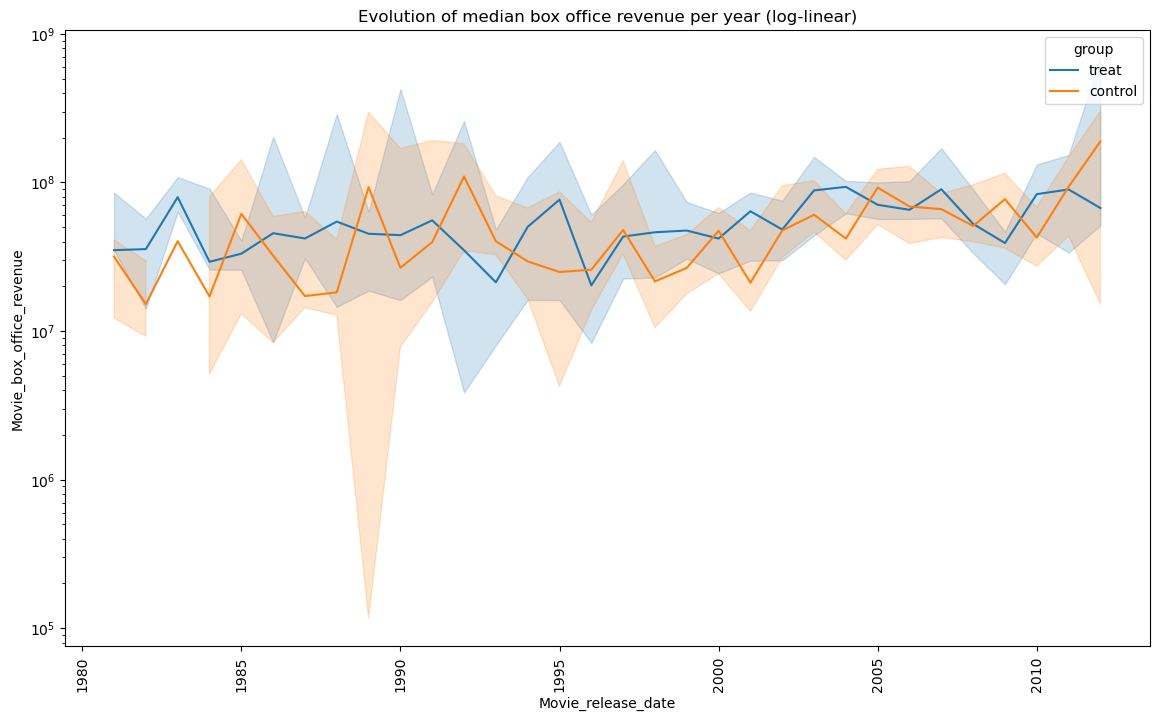

In [322]:
fig,ax = plt.subplots(figsize=(14,8))
sns.lineplot(data = df_match, x='Movie_release_date', y='Movie_box_office_revenue',estimator='median', ax=ax,hue='group')
plt.xticks(rotation=90)
plt.yscale('log')
plt.title('Evolution of median box office revenue per year (log-linear)')

Text(0.5, 1.0, 'Box office revenue (log-scale)')

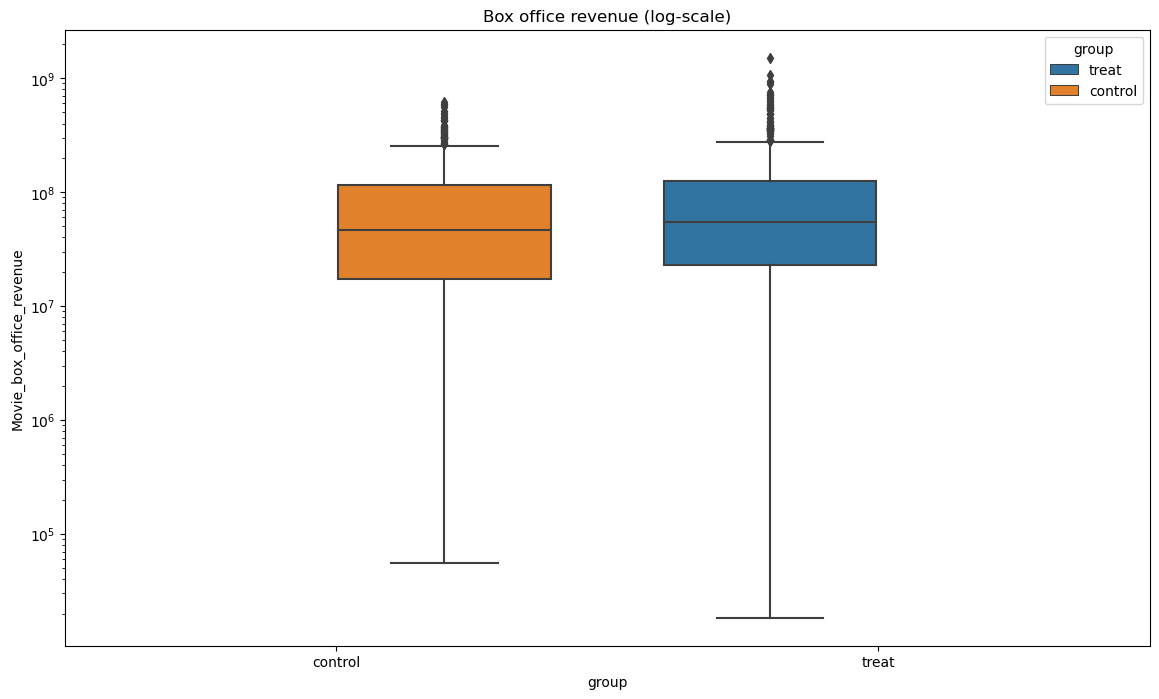

In [323]:
fig,ax = plt.subplots(figsize=(14,8))
sns.boxplot(data = df_match, y='Movie_box_office_revenue',x='group', hue='group',order=["control", "treat"], ax=ax)
#plt.xticks(rotation=90)
plt.yscale('log')
plt.title('Box office revenue (log-scale)')

Text(0.5, 1.0, 'Median box office revenue')

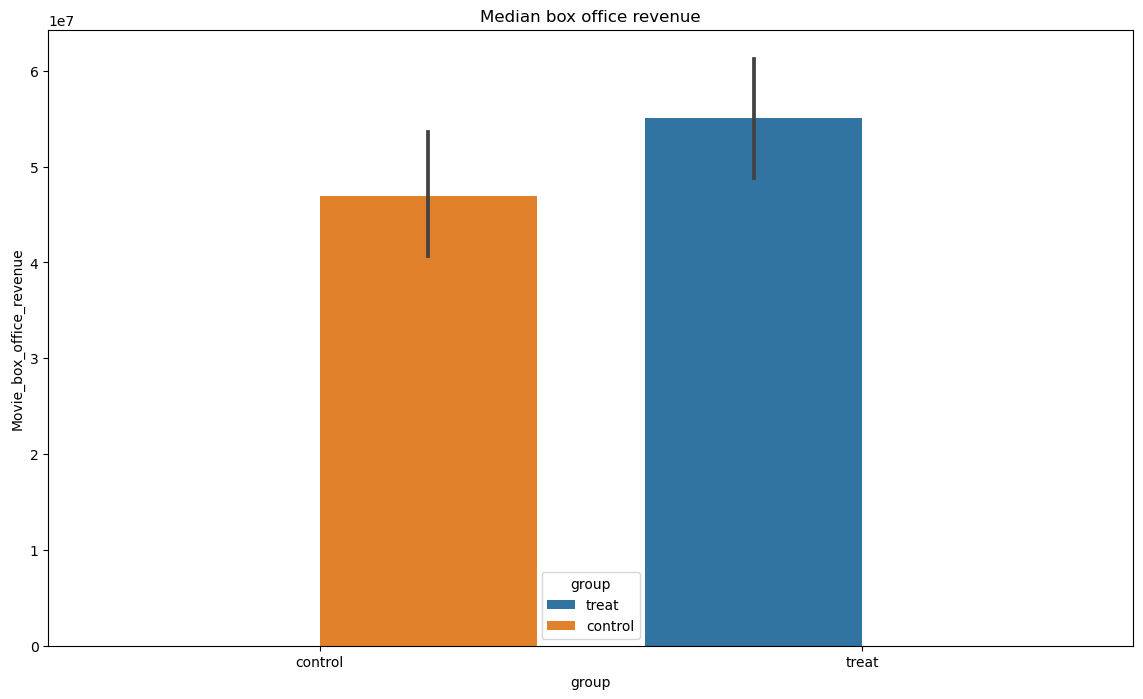

In [324]:
fig,ax = plt.subplots(figsize=(14,8))
sns.barplot(data = df_match, y='Movie_box_office_revenue',x='group',estimator='median', hue='group',order=["control", "treat"], ax=ax)
#plt.xticks(rotation=90)
#plt.yscale('log')
plt.title('Median box office revenue')

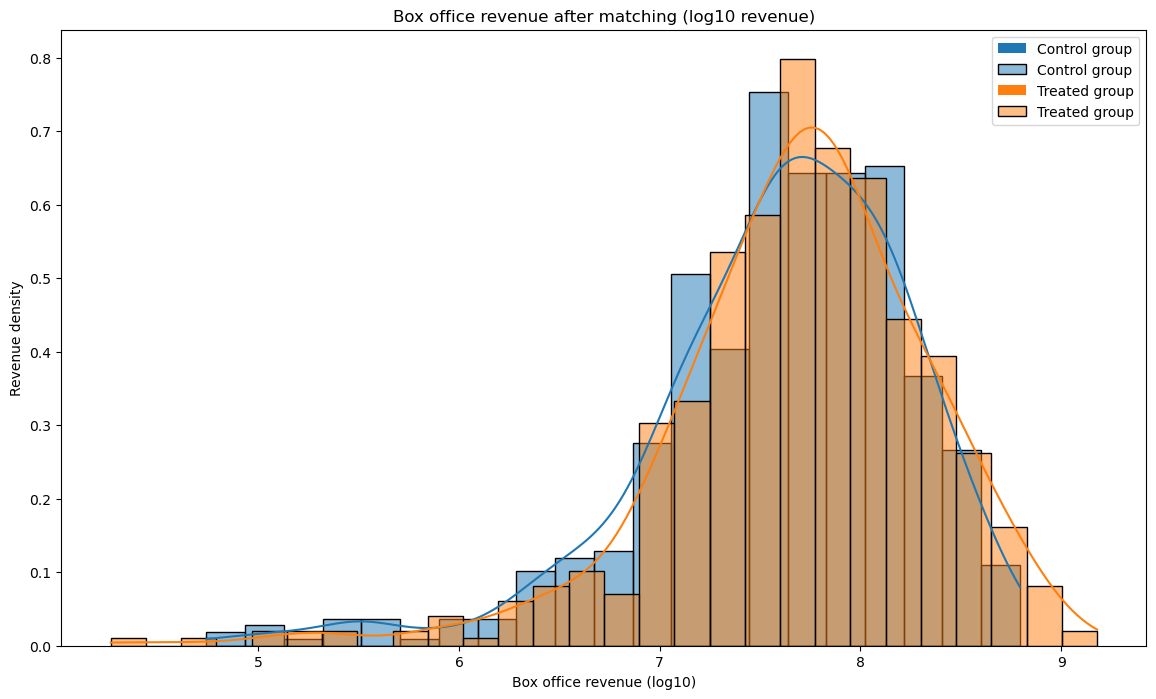

In [325]:
fig,ax = plt.subplots(figsize=(14,8))
sns.histplot(data = df_match[df_match.group == 'control']['log_revenue'],kde=True,stat='density', ax=ax,label='Control group')
sns.histplot(data = df_match[df_match.group == 'treat']['log_revenue'],kde=True,stat='density', ax=ax,label='Treated group')
ax.set(title='Box office revenue after matching (log10 revenue)',xlabel='Box office revenue (log10)', ylabel='Revenue density')
plt.legend()

Conclusion: we cannot conclude that one group performs better than the other, as the confidence intervals have a non-empty intersection, even though the graphs tend to show the opposite effect (films in which there are more women are more successful)

### Final linear regression

In [330]:
df_reg = df_match.copy()
df_reg.group = df_reg.group.apply(lambda x:0 if x=='treat' else 1)
df_reg

,genre,score,votes,director,writer,star,country,budget,company,Wikipedia_movie_ID,...,tconst,titleType,isAdult,genres,tconstIdentifier,averageRating,numVotes,log_revenue,log_budget,group
76,Comedy,6.9,68000.0,Ivan Reitman,Len Blum,Bill Murray,United States,10000000.0,Columbia Pictures,560511,...,tt0083131,movie,0,"Comedy,War",tt0083131,6.8,74616,7.930934,7.000000,0
77,Adventure,7.4,59000.0,John Boorman,Thomas Malory,Nigel Terry,United Kingdom,11000000.0,Cinema '84,250699,...,tt0082348,movie,0,"Adventure,Drama,Fantasy",tt0082348,7.3,62537,7.543664,7.041393,0
79,Action,6.9,42000.0,Desmond Davis,Beverley Cross,Laurence Olivier,United Kingdom,15000000.0,Charles H. Schneer Productions,948548,...,tt0082186,movie,0,"Action,Adventure,Family",tt0082186,6.9,44884,7.612784,7.176091,1
84,Crime,6.6,22000.0,Bob Rafelson,David Mamet,Jack Nicholson,West Germany,12000000.0,CIP Filmproduktion GmbH,5429460,...,tt0082934,movie,0,"Crime,Drama,Romance",tt0082934,6.6,24083,7.086360,7.079181,1
89,Drama,6.8,17000.0,Harold Becker,Darryl Ponicsan,George C. Scott,United States,14000000.0,Major Studio Partners,30863819,...,tt0083169,movie,0,Drama,tt0083169,6.7,18834,7.544108,7.146128,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4023,Action,6.6,296000.0,Simon West,Richard Wenk,Sylvester Stallone,United States,100000000.0,Lionsgate,33276254,...,tt1764651,movie,0,"Action,Adventure,Thriller",tt1764651,6.6,308114,8.461499,8.000000,0
4025,Animation,6.4,102000.0,Chris Renaud,Dr. Seuss,Zac Efron,United States,70000000.0,Universal Pictures,28063569,...,tt1482459,movie,0,"Adventure,Animation,Comedy",tt1482459,6.4,114076,8.539457,7.845098,1
4028,Action,6.3,148000.0,M\'e5ns M\'e5rlind,Len Wiseman,Kate Beckinsale,United States,70000000.0,Screen Gems,30009835,...,tt1496025,movie,0,"Action,Fantasy,Horror",tt1496025,6.3,155201,8.204426,7.845098,1
4039,Action,6.8,342000.0,Barry Sonnenfeld,Etan Cohen,Will Smith,United States,225000000.0,Columbia Pictures,13049327,...,tt1409024,movie,0,"Action,Adventure,Comedy",tt1409024,6.8,363853,8.795203,8.352183,1


In [419]:
mod = smf.ols(formula='log_revenue ~ log_budget + Movie_release_date +C(group)',data=df_reg)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            log_revenue   R-squared:                       0.390
Model:                            OLS   Adj. R-squared:                  0.389
Method:                 Least Squares   F-statistic:                     239.8
Date:                Mon, 19 Dec 2022   Prob (F-statistic):          3.13e-120
Time:                        17:46:35   Log-Likelihood:                -860.51
No. Observations:                1128   AIC:                             1729.
Df Residuals:                    1124   BIC:                             1749.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -2.4458      4

This very simple model captures almost $40\%$ of the variance of the data in the match dataset. However, the estimated coefficients of `group` and `Movie_release_date` have very high p-values, as well as the intercept.
Here the budget is the most predictive variable, and in fact the regression `log_revenue` in function of `log_budget` only captures almost as much variance ($R^2 =0.390$).

In [418]:
mod = smf.ols(formula='averageRating ~ log_budget + C(group)',data=df_reg)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          averageRating   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     17.49
Date:                Mon, 19 Dec 2022   Prob (F-statistic):           3.32e-08
Time:                        17:41:55   Log-Likelihood:                -1546.3
No. Observations:                1128   AIC:                             3099.
Df Residuals:                    1125   BIC:                             3114.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         7.4190      0.535     13.857

This regression shows that our variables do not explain the rating at all... We did not include the movie release date as it should not have an impact on the rating of a film.